<a href="https://colab.research.google.com/github/snicolau/HumanBodyOcclusionMaskEstimation/blob/main/05_Deocclusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OCCLUSION MASK

## 0. Load images

In [ ]:
import os
!pip install iglovikov_helper_functions
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
import matplotlib.pyplot as plt
from pylab import imshow, imsave

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = '/content/drive/MyDrive/IR/frames'

In [ ]:
!mkdir '/content/movies/'
!cp -av '/content/drive/MyDrive/IR/frames' '/content/movies/'
!mv '/content/movies/frames' '/content/movies/images'

In [ ]:
def load_images_from_folder(folder):
    images = []
    dir = os.listdir(folder)
    dir.reverse()
    for filename in dir:
        img = load_rgb(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
#images = load_images_from_folder(folder)

plt.figure(figsize=(20,10),dpi=400)
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

## Modal mask

### 1.1. People segmentation 
[https://github.com/ternaus/people_segmentation](https://github.com/ternaus/people_segmentation)

In [ ]:
import numpy as np
import cv2
import torch
import albumentations as albu
!wget https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg > /dev/null
!pip install people_segmentation  > /dev/null
from people_segmentation.pre_trained_models import create_model

--2022-11-09 01:50:19--  https://habrastorage.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving habrastorage.org (habrastorage.org)... 51.89.30.72
Connecting to habrastorage.org (habrastorage.org)|51.89.30.72|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://hsto.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg [following]
--2022-11-09 01:50:20--  https://hsto.org/webt/em/l7/cr/eml7crxnxftrimsmolwjegqcrp4.jpeg
Resolving hsto.org (hsto.org)... 104.26.13.161, 172.67.71.175, 104.26.12.161, ...
Connecting to hsto.org (hsto.org)|104.26.13.161|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55211 (54K) [image/jpeg]
Saving to: ‘eml7crxnxftrimsmolwjegqcrp4.jpeg’

eml7crxnxftrimsmolw 100%[===================>]  53.92K  --.-KB/s    in 0.01s   

2022-11-09 01:50:21 (4.58 MB/s) - ‘eml7crxnxftrimsmolwjegqcrp4.jpeg’ saved [55211/55211]



In [ ]:
model = create_model("Unet_2020-07-20")
model.eval();

In [ ]:
images = load_images_from_folder('/content/upload/content/movies/results/input_images')

In [ ]:
ref_vec = []
dst_vec = []
mask_vec = []

for image in images:
  if not in_list(ref_vec,image):
    ref_vec.append(image)
    transform = albu.Compose([albu.Normalize(p=1)], p=1)

    padded_image, pads = pad(image, factor=32, border=cv2.BORDER_CONSTANT)

    x = transform(image=padded_image)["image"]
    x = torch.unsqueeze(tensor_from_rgb_image(x), 0)

    with torch.no_grad():
      prediction = model(x)[0][0]

    mask = (prediction > 0).cpu().numpy().astype(np.uint8)

    mask = unpad(mask, pads)
    mask_vec.append(mask)

    dst = cv2.addWeighted(image, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (0, 255, 0)).astype(np.uint8), 0.5, 0) 
    dst_vec.append(dst)
   

In [ ]:
plt.figure(figsize=(20,10),dpi=400)
columns = 5
for i, image in enumerate(dst_vec):
    plt.subplot(len(dst_vec) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

(292, 528)


(-0.5, 719.5, 383.5, -0.5)

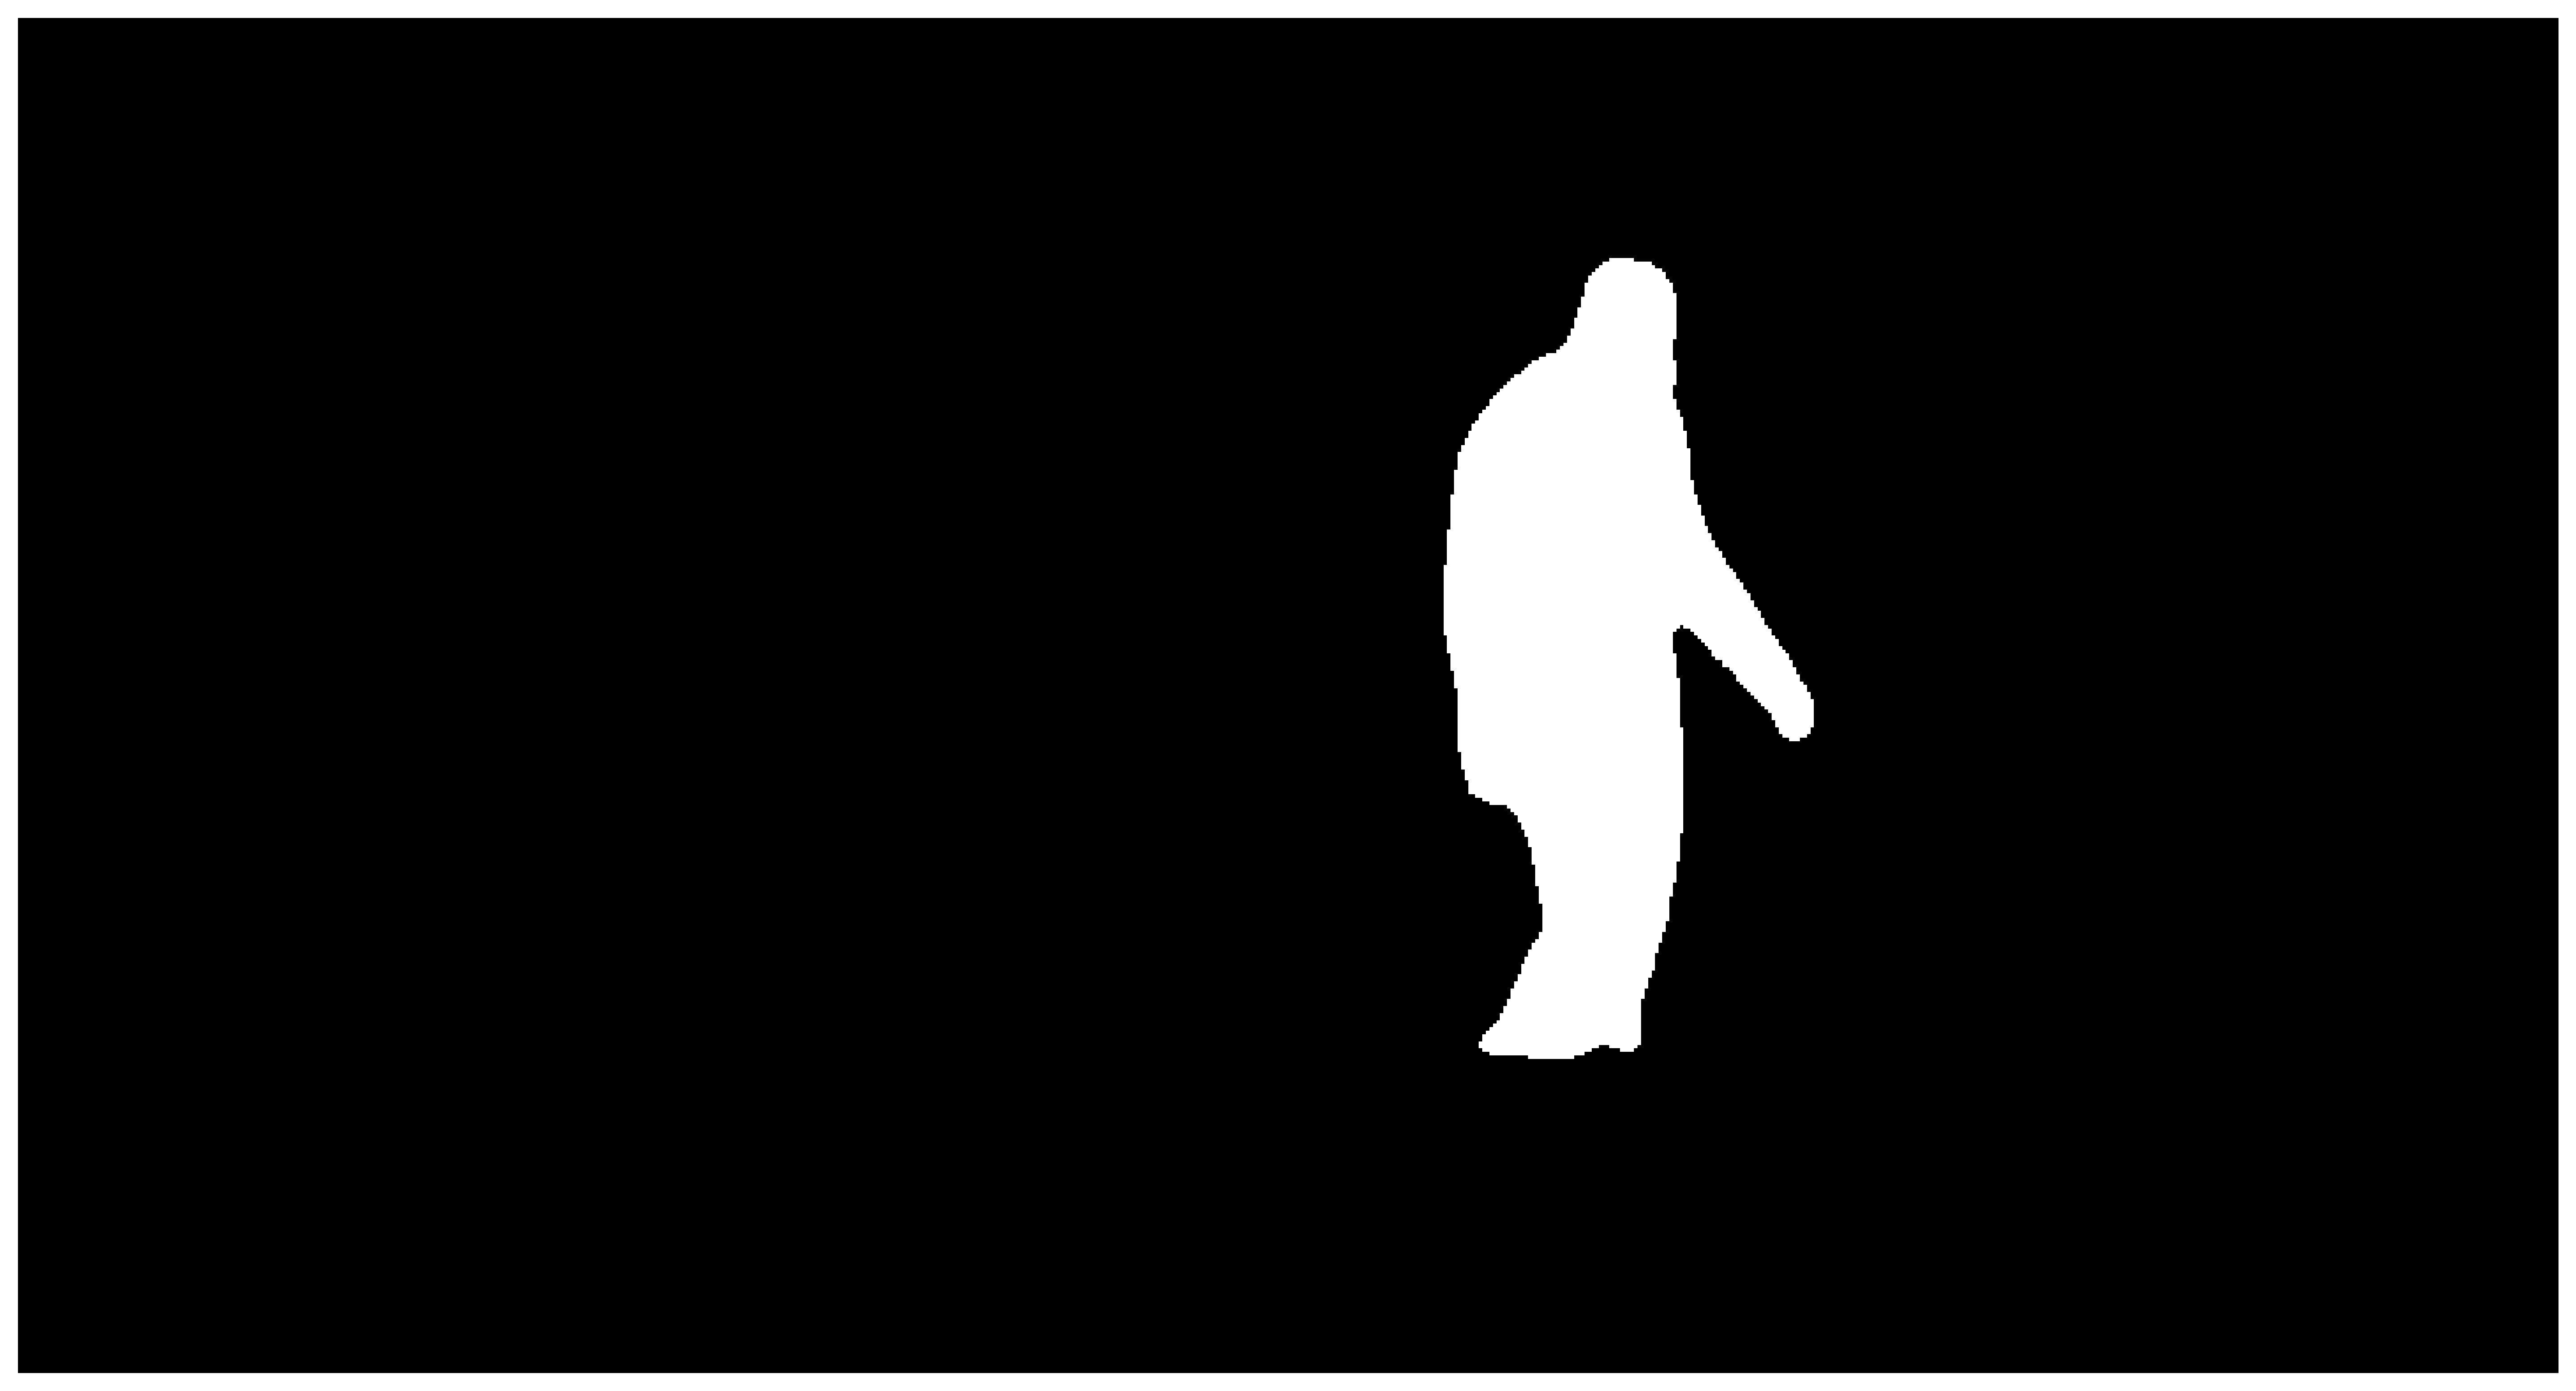

In [ ]:
plt.figure(figsize=(20,10),dpi=400)
#model = cv2.cvtColor(images[0].copy(), cv2.COLOR_RGB2RGBA)
mask_ex = (cv2.cvtColor(mask_vec[14], cv2.COLOR_GRAY2RGBA) * (255, 255, 255, 1)).astype(np.uint8)

#occ = model.copy()
#occ[np.where(mask[:, :, 1] == 255)] = (0, 0, 0, 0)

#print(model.shape)
print(mask_ex.shape)
#plt.imshow(cv2.addWeighted(model, 1, mask, 0.75, 0))
#plt.imshow(occ)
plt.imshow(mask_ex)
plt.xticks([])
plt.yticks([])
plt.axis('off')

(-0.5, 719.5, 383.5, -0.5)

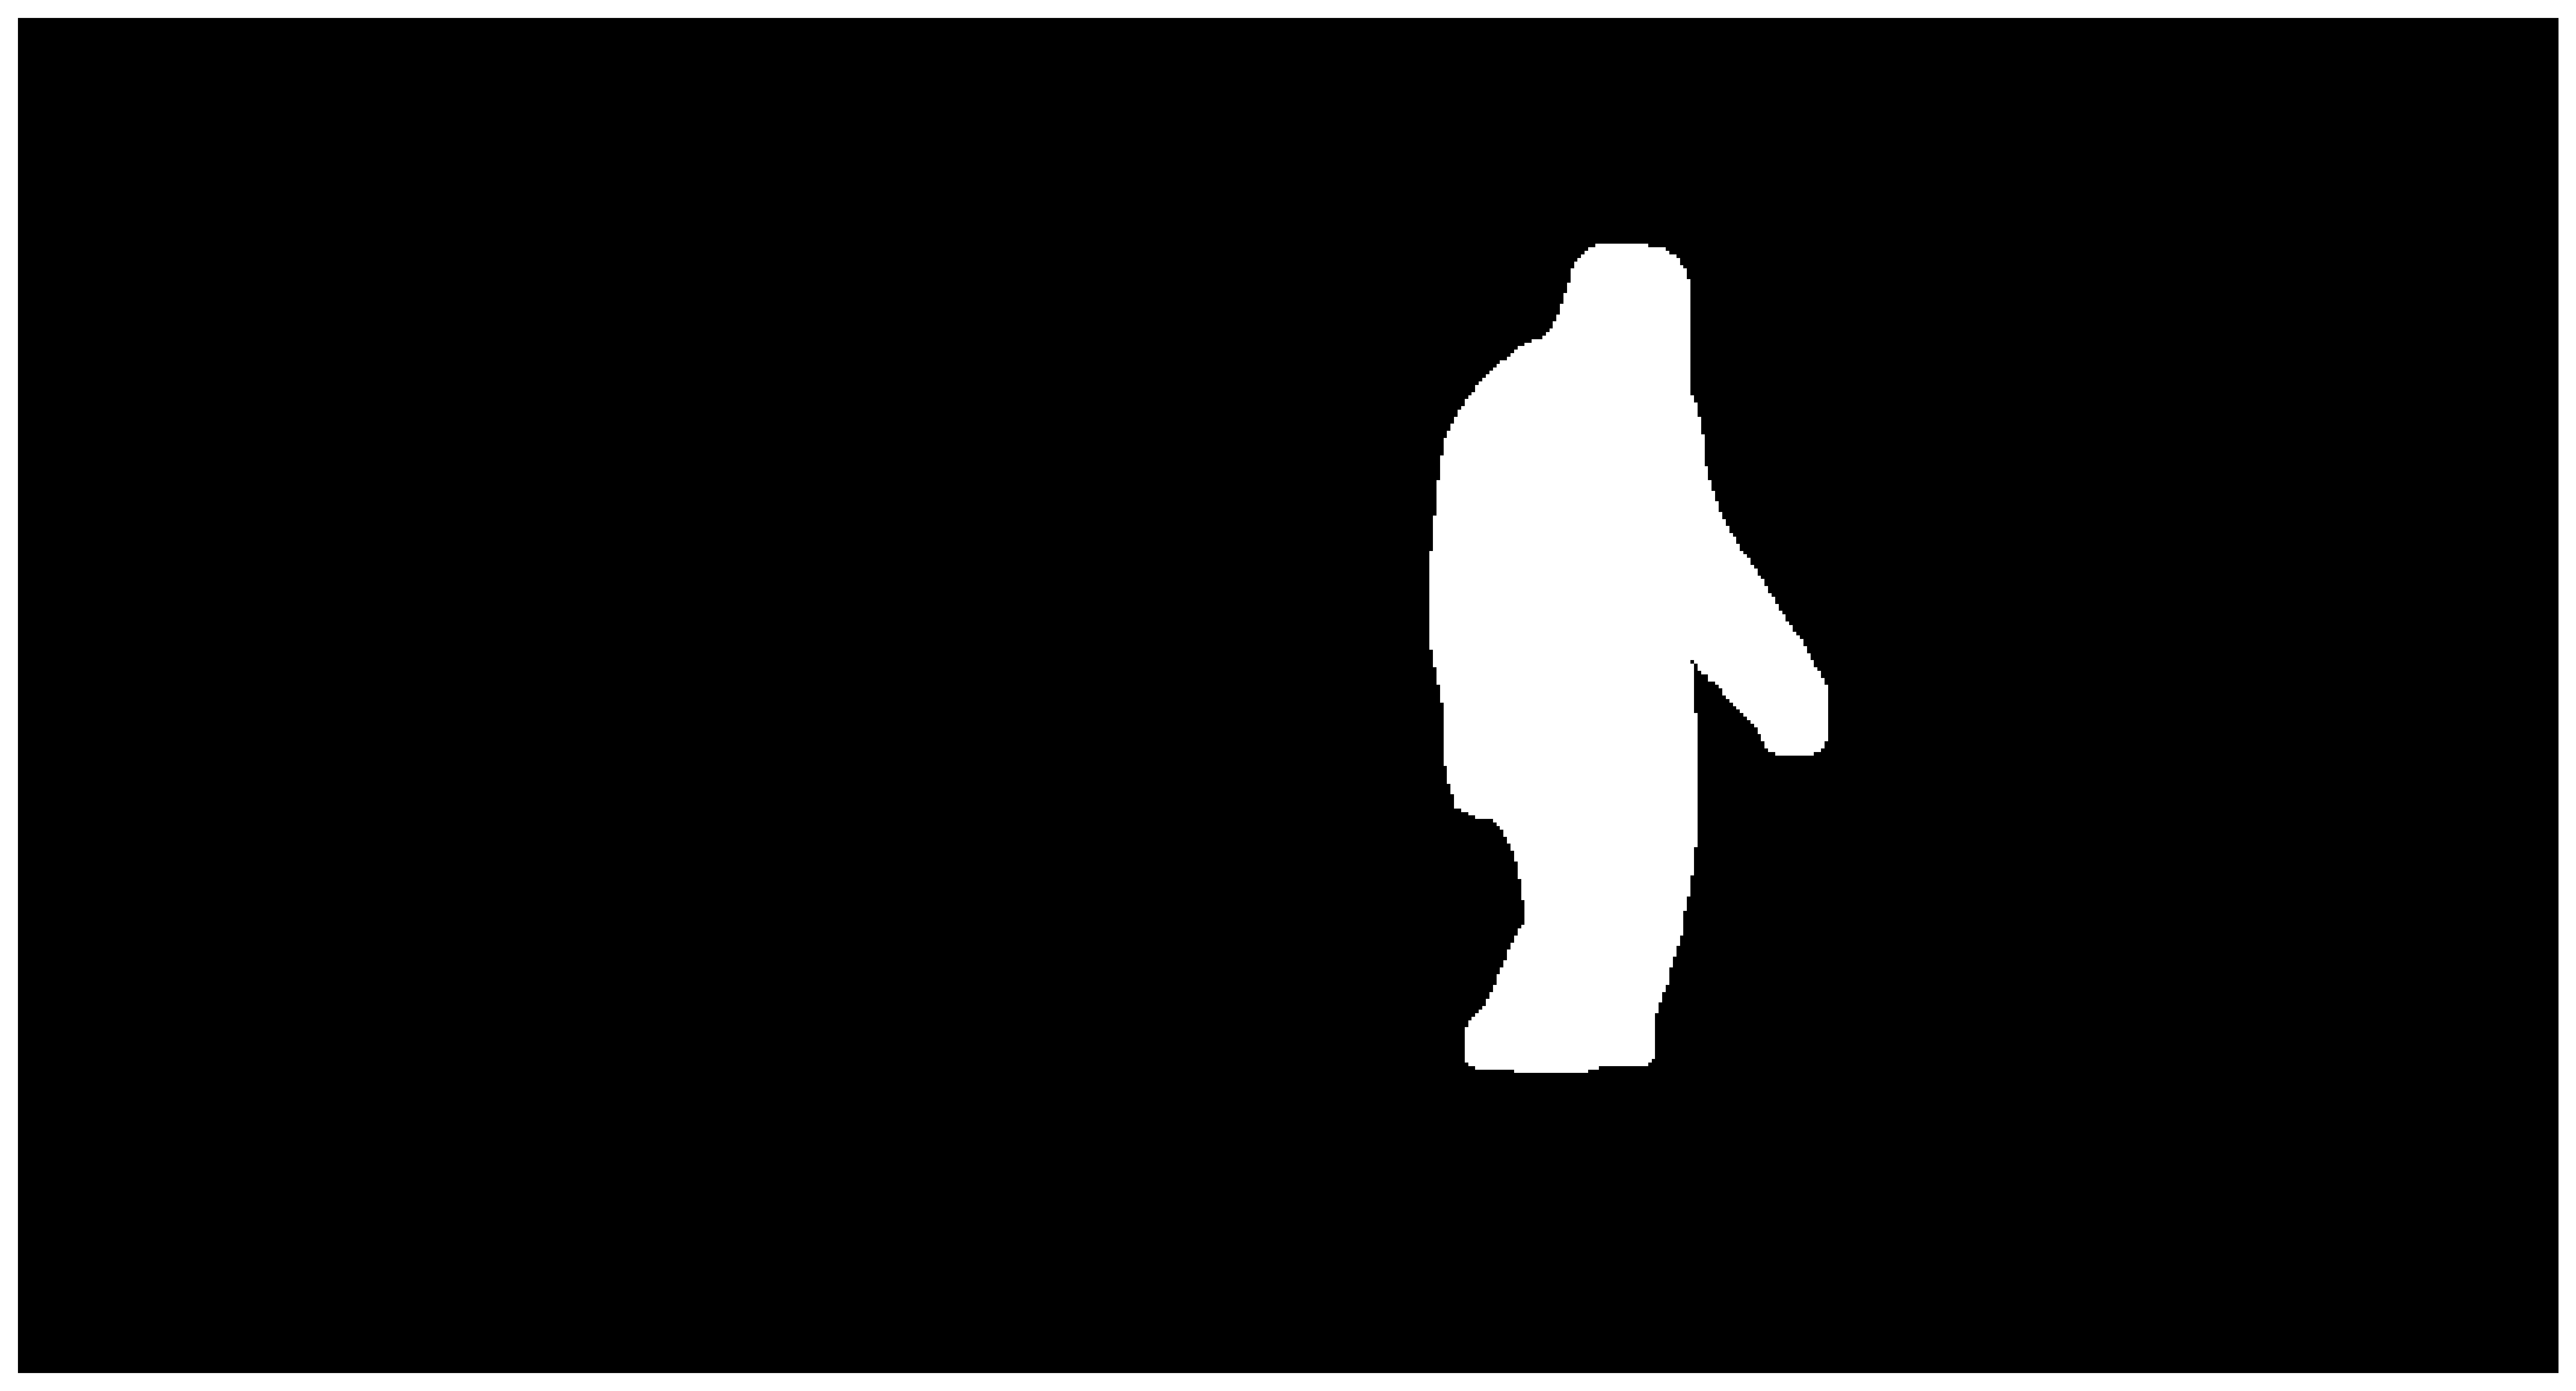

In [ ]:
plt.figure(figsize=(20,10),dpi=400)
kernel = np.ones((5, 5), np.uint8)
 
mask_dilation = cv2.dilate(mask_ex, kernel, iterations=2)
plt.imshow(mask_dilation)
plt.xticks([])
plt.yticks([])
plt.axis('off')

## Background extraction

In [ ]:
!pip install -qq -U diffusers==0.6.0 transformers ftfy gradio
!pip install git+https://github.com/huggingface/diffusers.git

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
import inspect
from typing import List, Optional, Union

import numpy as np
import torch

import PIL
import gradio as gr
from diffusers import StableDiffusionInpaintPipeline

In [ ]:
device = "cuda"
model_path = "runwayml/stable-diffusion-inpainting"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_path,
    revision="fp16", 
    torch_dtype=torch.float16,
    use_auth_token=True
).to(device)

In [ ]:
import requests
from io import BytesIO

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid



In [ ]:
from PIL import Image

In [ ]:
model = Image.fromarray(ref_vec[19].copy()).resize((512, 512))
mask = Image.fromarray((cv2.cvtColor(mask_vec[19], cv2.COLOR_GRAY2RGB) * (255, 255, 255)).astype(np.uint8)).resize((512, 512))

In [ ]:
prompt = "background"

guidance_scale=7.5
num_samples = 1
generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

outputs = pipe(
    prompt=prompt,
    image=model,
    mask_image=mask,
    guidance_scale=guidance_scale,
    generator=generator,
    num_images_per_prompt=num_samples,
).images

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
images[19].shape[0]

304

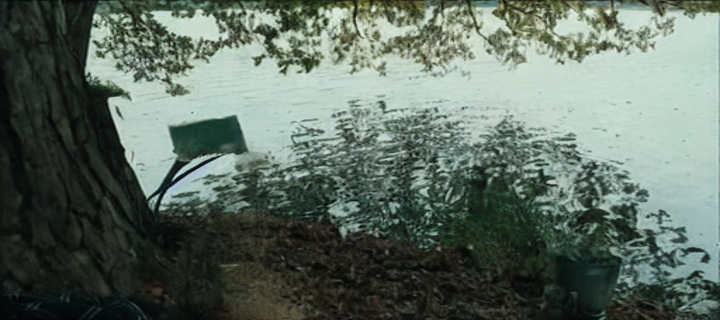

In [ ]:
output = outputs[0]
output.resize((ref_vec[19].shape[1], ref_vec[19].shape[0]))


In [ ]:
plt.figure(figsize=(20,10),dpi=400)
columns = 5
guidance_scale=7.5
num_samples = 1
kernel = np.ones((5, 5), np.uint8)

bckgclean_list = []

for i, image in enumerate(dst_vec):
    model = Image.fromarray(ref_vec[i].copy()).resize((512, 512))   
    mask_dilation = cv2.dilate(mask_vec[i], kernel, iterations=2)
    mask = Image.fromarray((cv2.cvtColor(mask_dilation, cv2.COLOR_GRAY2RGB) * (255, 255, 255)).astype(np.uint8)).resize((512, 512))

    prompt = "background"

    generator = torch.Generator(device="cuda").manual_seed(0) # change the seed to get different results

    outputs = pipe(
        prompt=prompt,
        image=model,
        mask_image=mask,
        guidance_scale=guidance_scale,
        generator=generator,
        num_images_per_prompt=num_samples,
    ).images

    output = outputs[0]
    output_res = output.resize((ref_vec[i].shape[1], ref_vec[i].shape[0]))

    bckgclean_list.append(output_res)

    plt.subplot(len(dst_vec) / columns + 1, columns, i + 1)
    plt.imshow(output_res)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

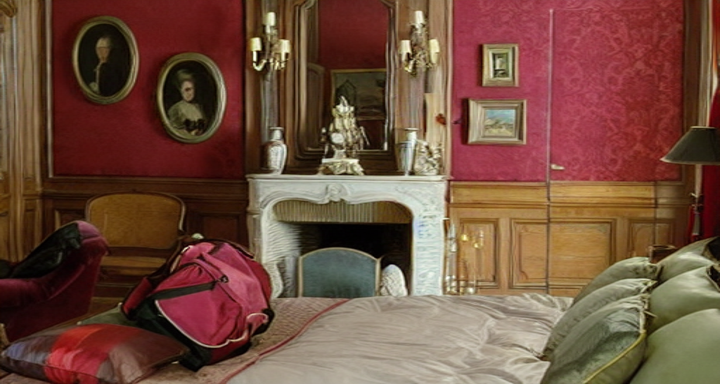

In [ ]:
example_bckg = bckgclean_list[5]
example_bckg.resize((ref_vec[5].shape[1], ref_vec[5].shape[0]))

## 3D Model

In [ ]:
%cd /content/upload/

/content/upload


In [ ]:
!unzip /content/upload/movies.zip

In [ ]:
def images_the_same(im1, im2):
    """
    :return: True if images are the same, False if images are not the same
    """

    if im1.shape != im2.shape:
        return False

    difference = cv2.subtract(im1, im2)
    b, g, r = cv2.split(difference)

    if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
        return True
    return False

def in_list(im_list, image):
  for im in im_list:
    if images_the_same(image,im): 
      return True
  return False

def num_list(im_list, image):
  i = 0
  for im in im_list:
    if images_the_same(im, image): 
      return i
    i = i+1
  return -1

In [ ]:
simplx_images = load_images_from_folder('/content/upload/content/movies/results/rendered_smplifyx_meshes')
meshes = '/content/upload/content/movies/results/meshes'
images = load_images_from_folder('/content/upload/content/movies/images')

plt.figure(figsize=(20,10),dpi=400)
columns = 5
i = 0
bckg_list=[]
mesh_list=[]

listdir = os.listdir('/content/upload/content/movies/results/input_images')
listdir.reverse()

for filename in listdir:
    image = cv2.imread(os.path.join('/content/upload/content/movies/results/rendered_smplifyx_meshes',filename), cv2.IMREAD_UNCHANGED) 
    bckg = load_rgb(os.path.join('/content/upload/content/movies/results/input_images',filename))
    if not in_list(bckg_list,bckg):
      plt.subplot(len(simplx_images) / columns + 1, columns, i + 1)
      i = i + 1
      plt.imshow(bckg)
      bckg_list.append(bckg)
      mesh_list.append(image)
      plt.imshow(image)
    else:
      ii = num_list(bckg_list,bckg)
      prev = mesh_list[ii]
      mesh_list[ii] = cv2.addWeighted(image, 1, prev, 1, 0)
      plt.subplot(len(simplx_images) / columns + 1, columns, ii + 1)
      plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

plt.subplots_adjust(wspace=-0.8, hspace=0.2)

(-0.5, 719.5, 383.5, -0.5)

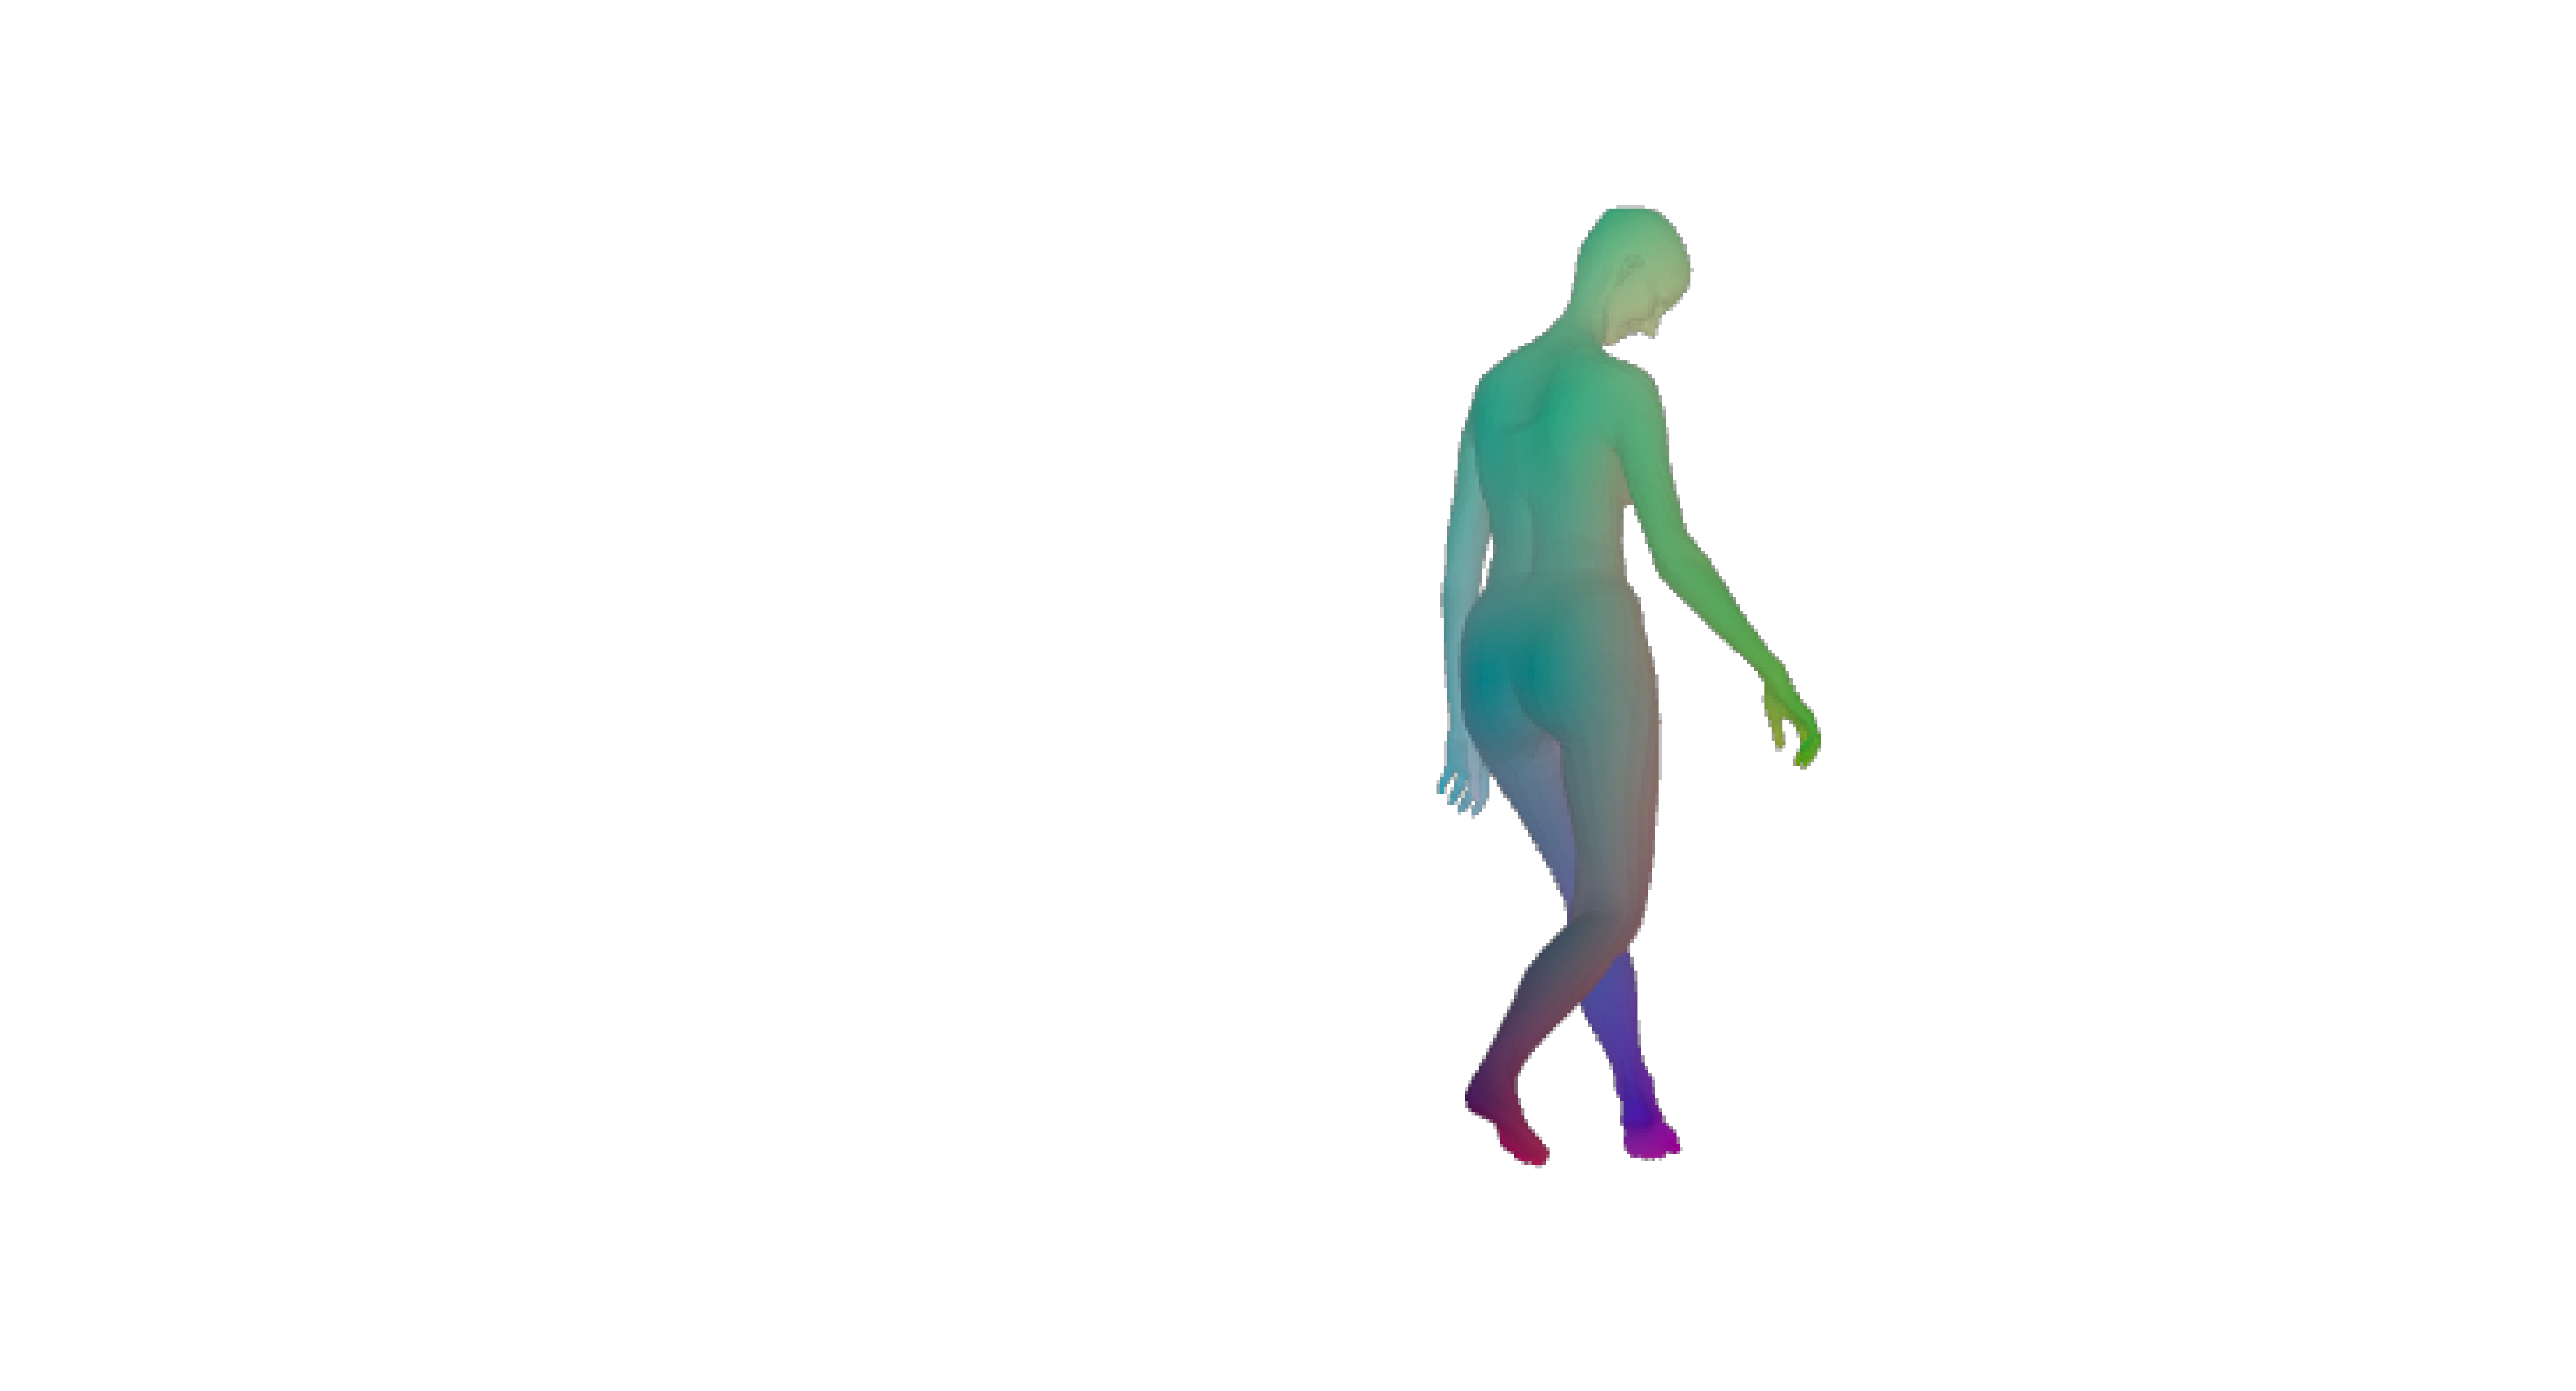

In [ ]:
plt.figure(figsize=(20,10),dpi=400)
plt.imshow(mesh_list[25])
plt.xticks([])
plt.yticks([])
plt.axis('off')

(384, 720, 4)
(384, 720, 4)


(-0.5, 719.5, 383.5, -0.5)

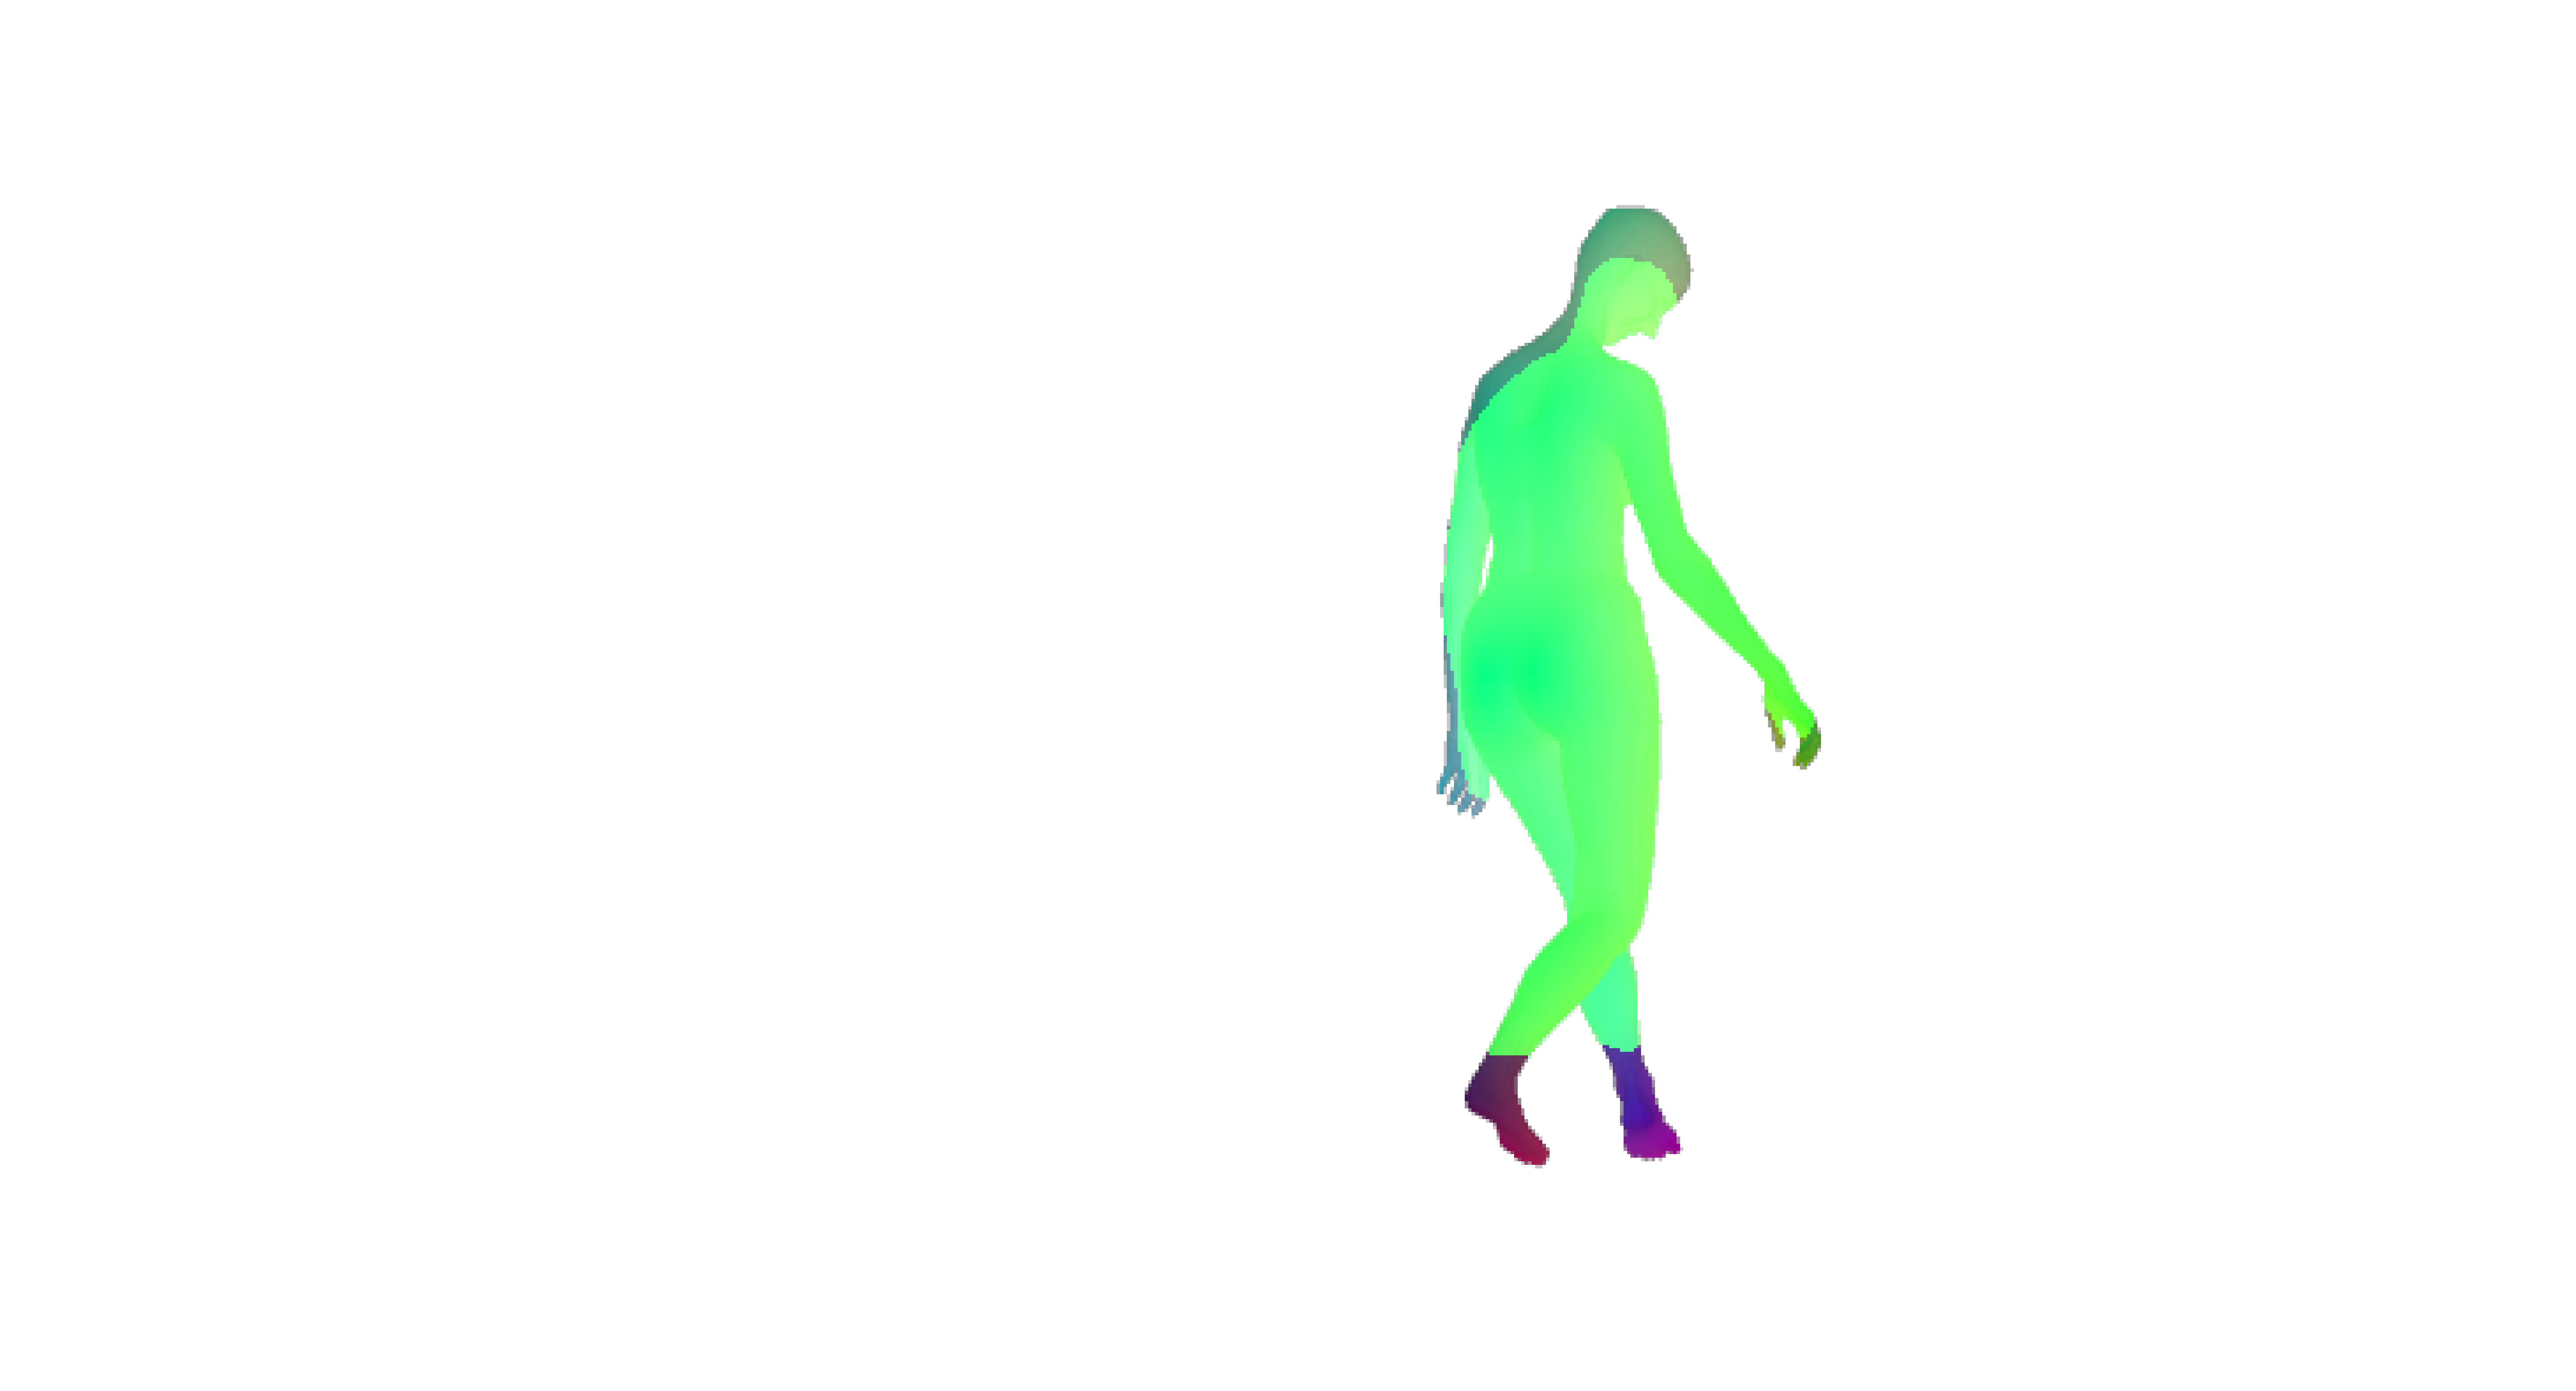

In [ ]:
plt.figure(figsize=(20,10),dpi=400)
model = mesh_list[25].copy()
mask = (cv2.cvtColor(mask_vec[5], cv2.COLOR_GRAY2RGBA) * (0, 255, 0, 0)).astype(np.uint8)
print(model.shape)
print(mask.shape)
plt.imshow(cv2.addWeighted(model, 1, mask, 0.75, 0))
plt.xticks([])
plt.yticks([])
plt.axis('off')

(384, 720, 4)
(384, 720, 4)


(-0.5, 719.5, 383.5, -0.5)

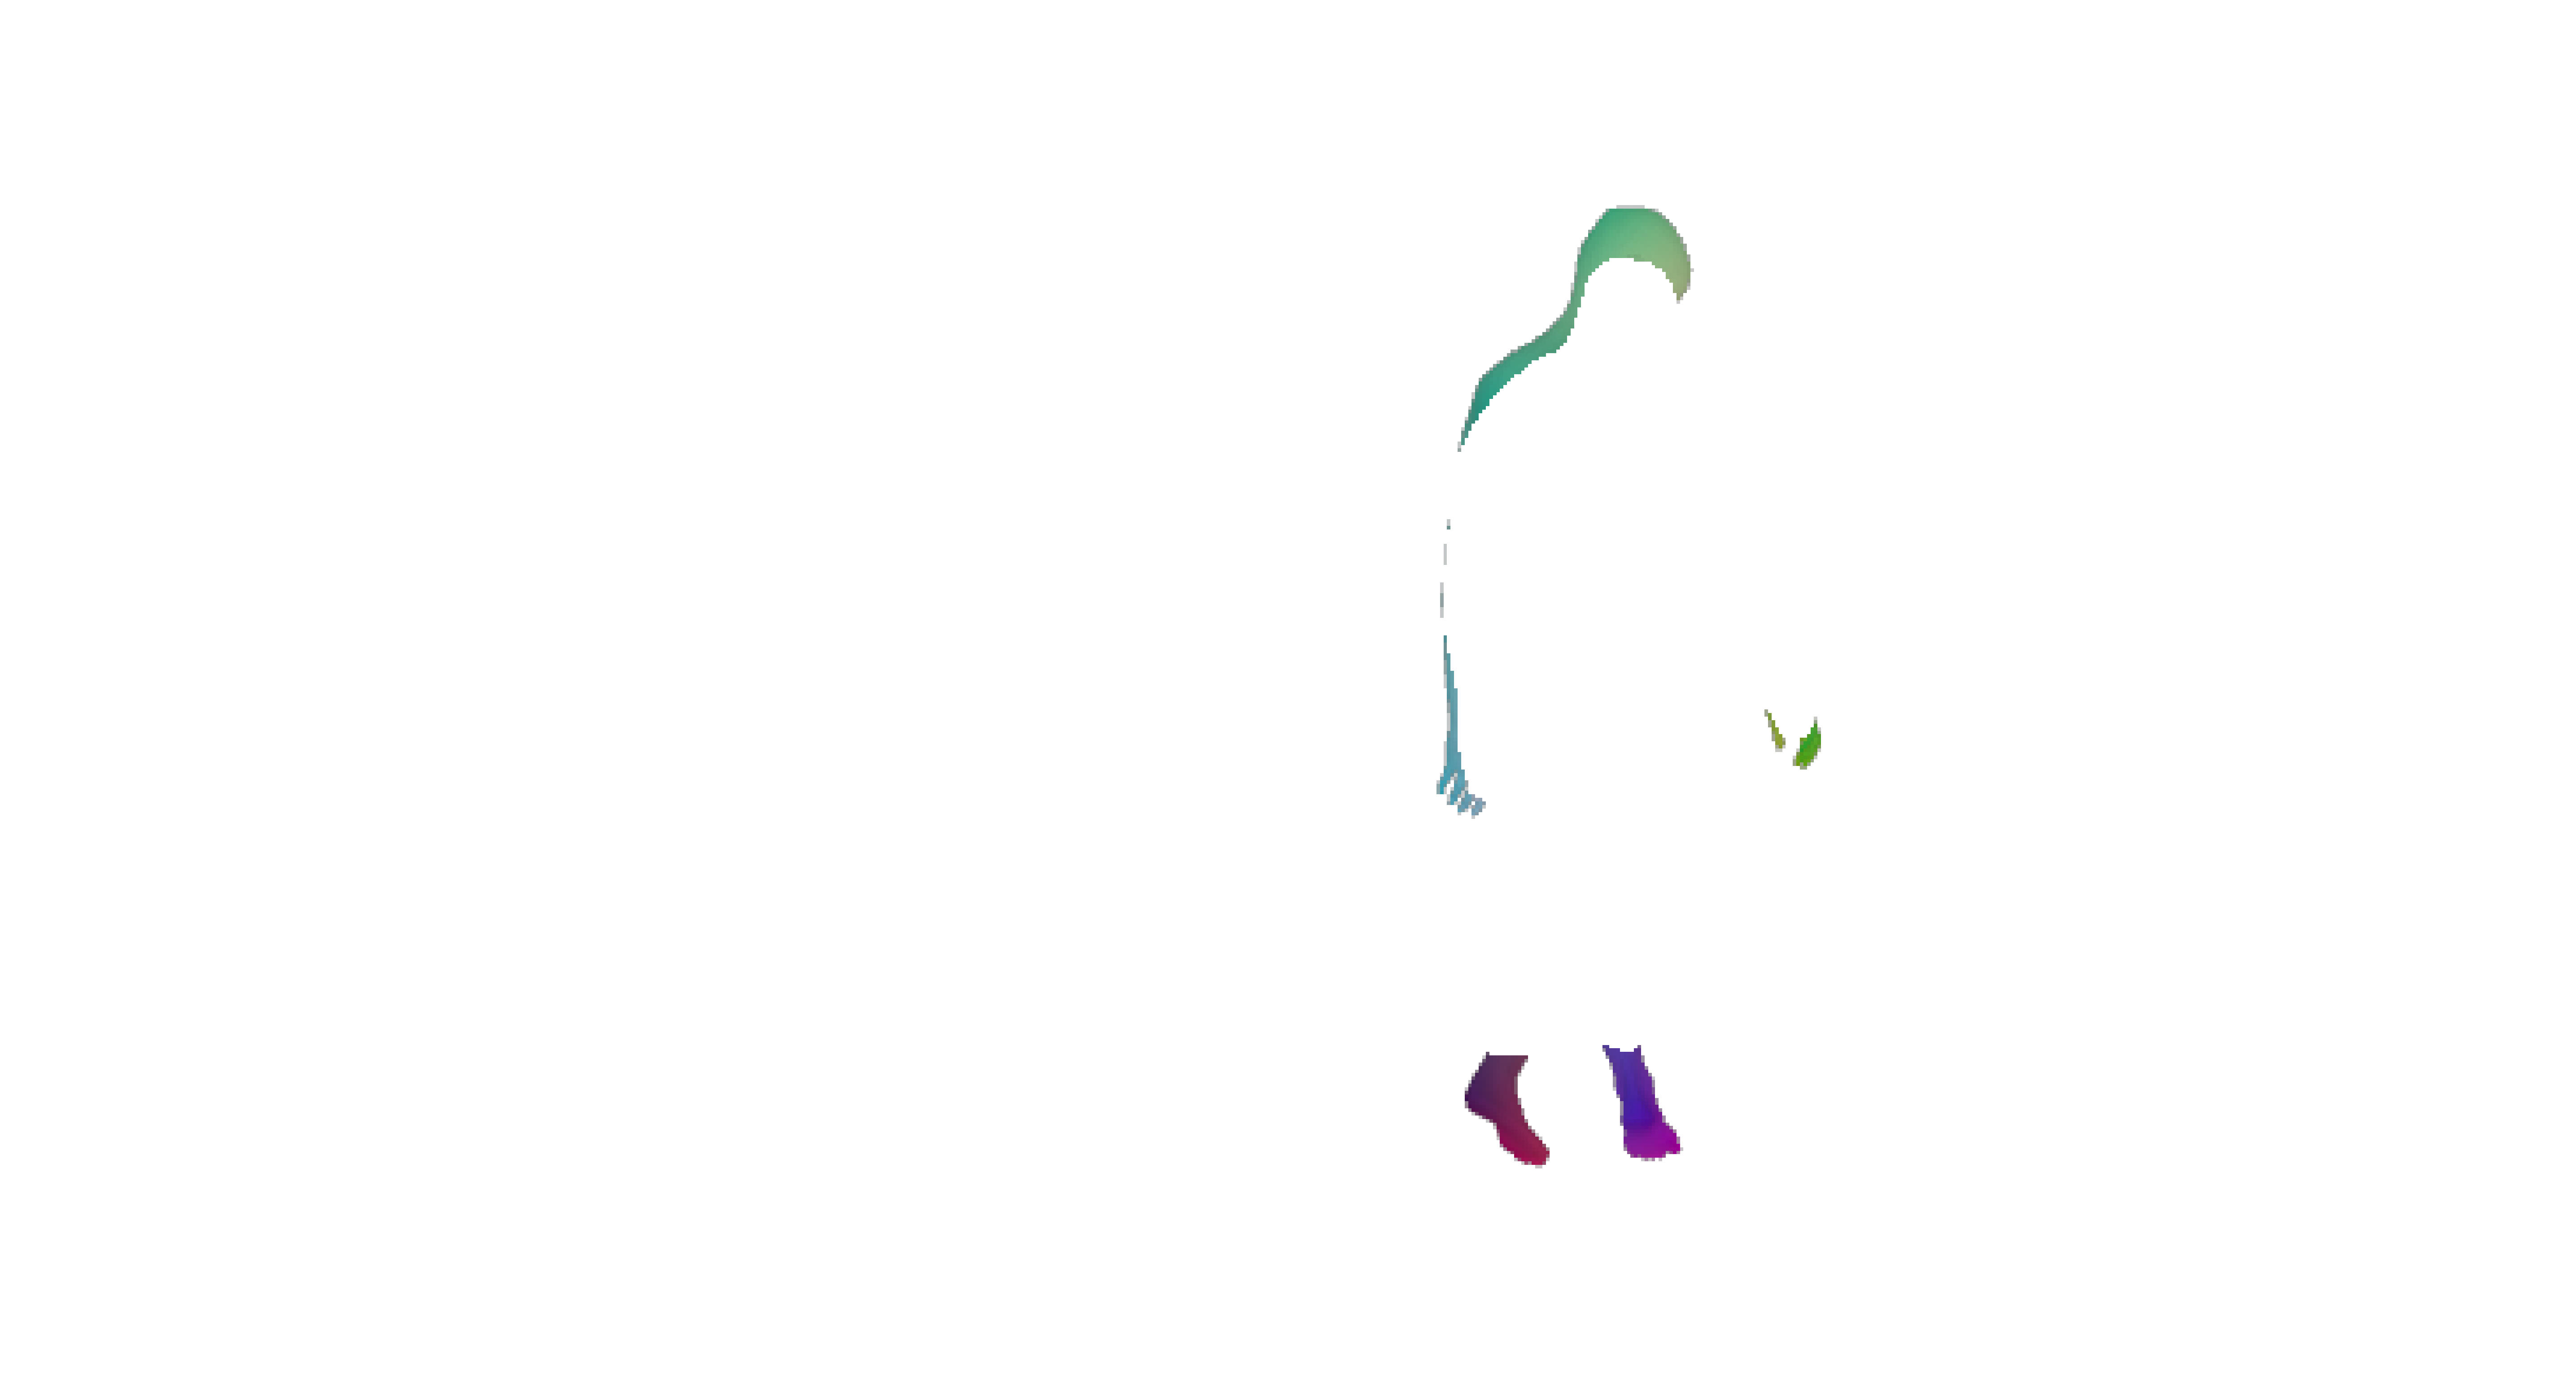

In [ ]:
plt.figure(figsize=(20,10),dpi=400)
model = mesh_list[25].copy()
mask = mask_vec[5].copy()
mask = (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGBA) * (0, 255, 0, 1)).astype(np.uint8)
occ = model.copy()
occ[np.where(mask[:, :, 1] == 255)] = (0, 0, 0, 0)
print(model.shape)
print(mask.shape)
#plt.imshow(cv2.addWeighted(model, 1, mask, 0.75, 0))
plt.imshow(occ)
plt.xticks([])
plt.yticks([])
plt.axis('off')

(-0.5, 719.5, 383.5, -0.5)

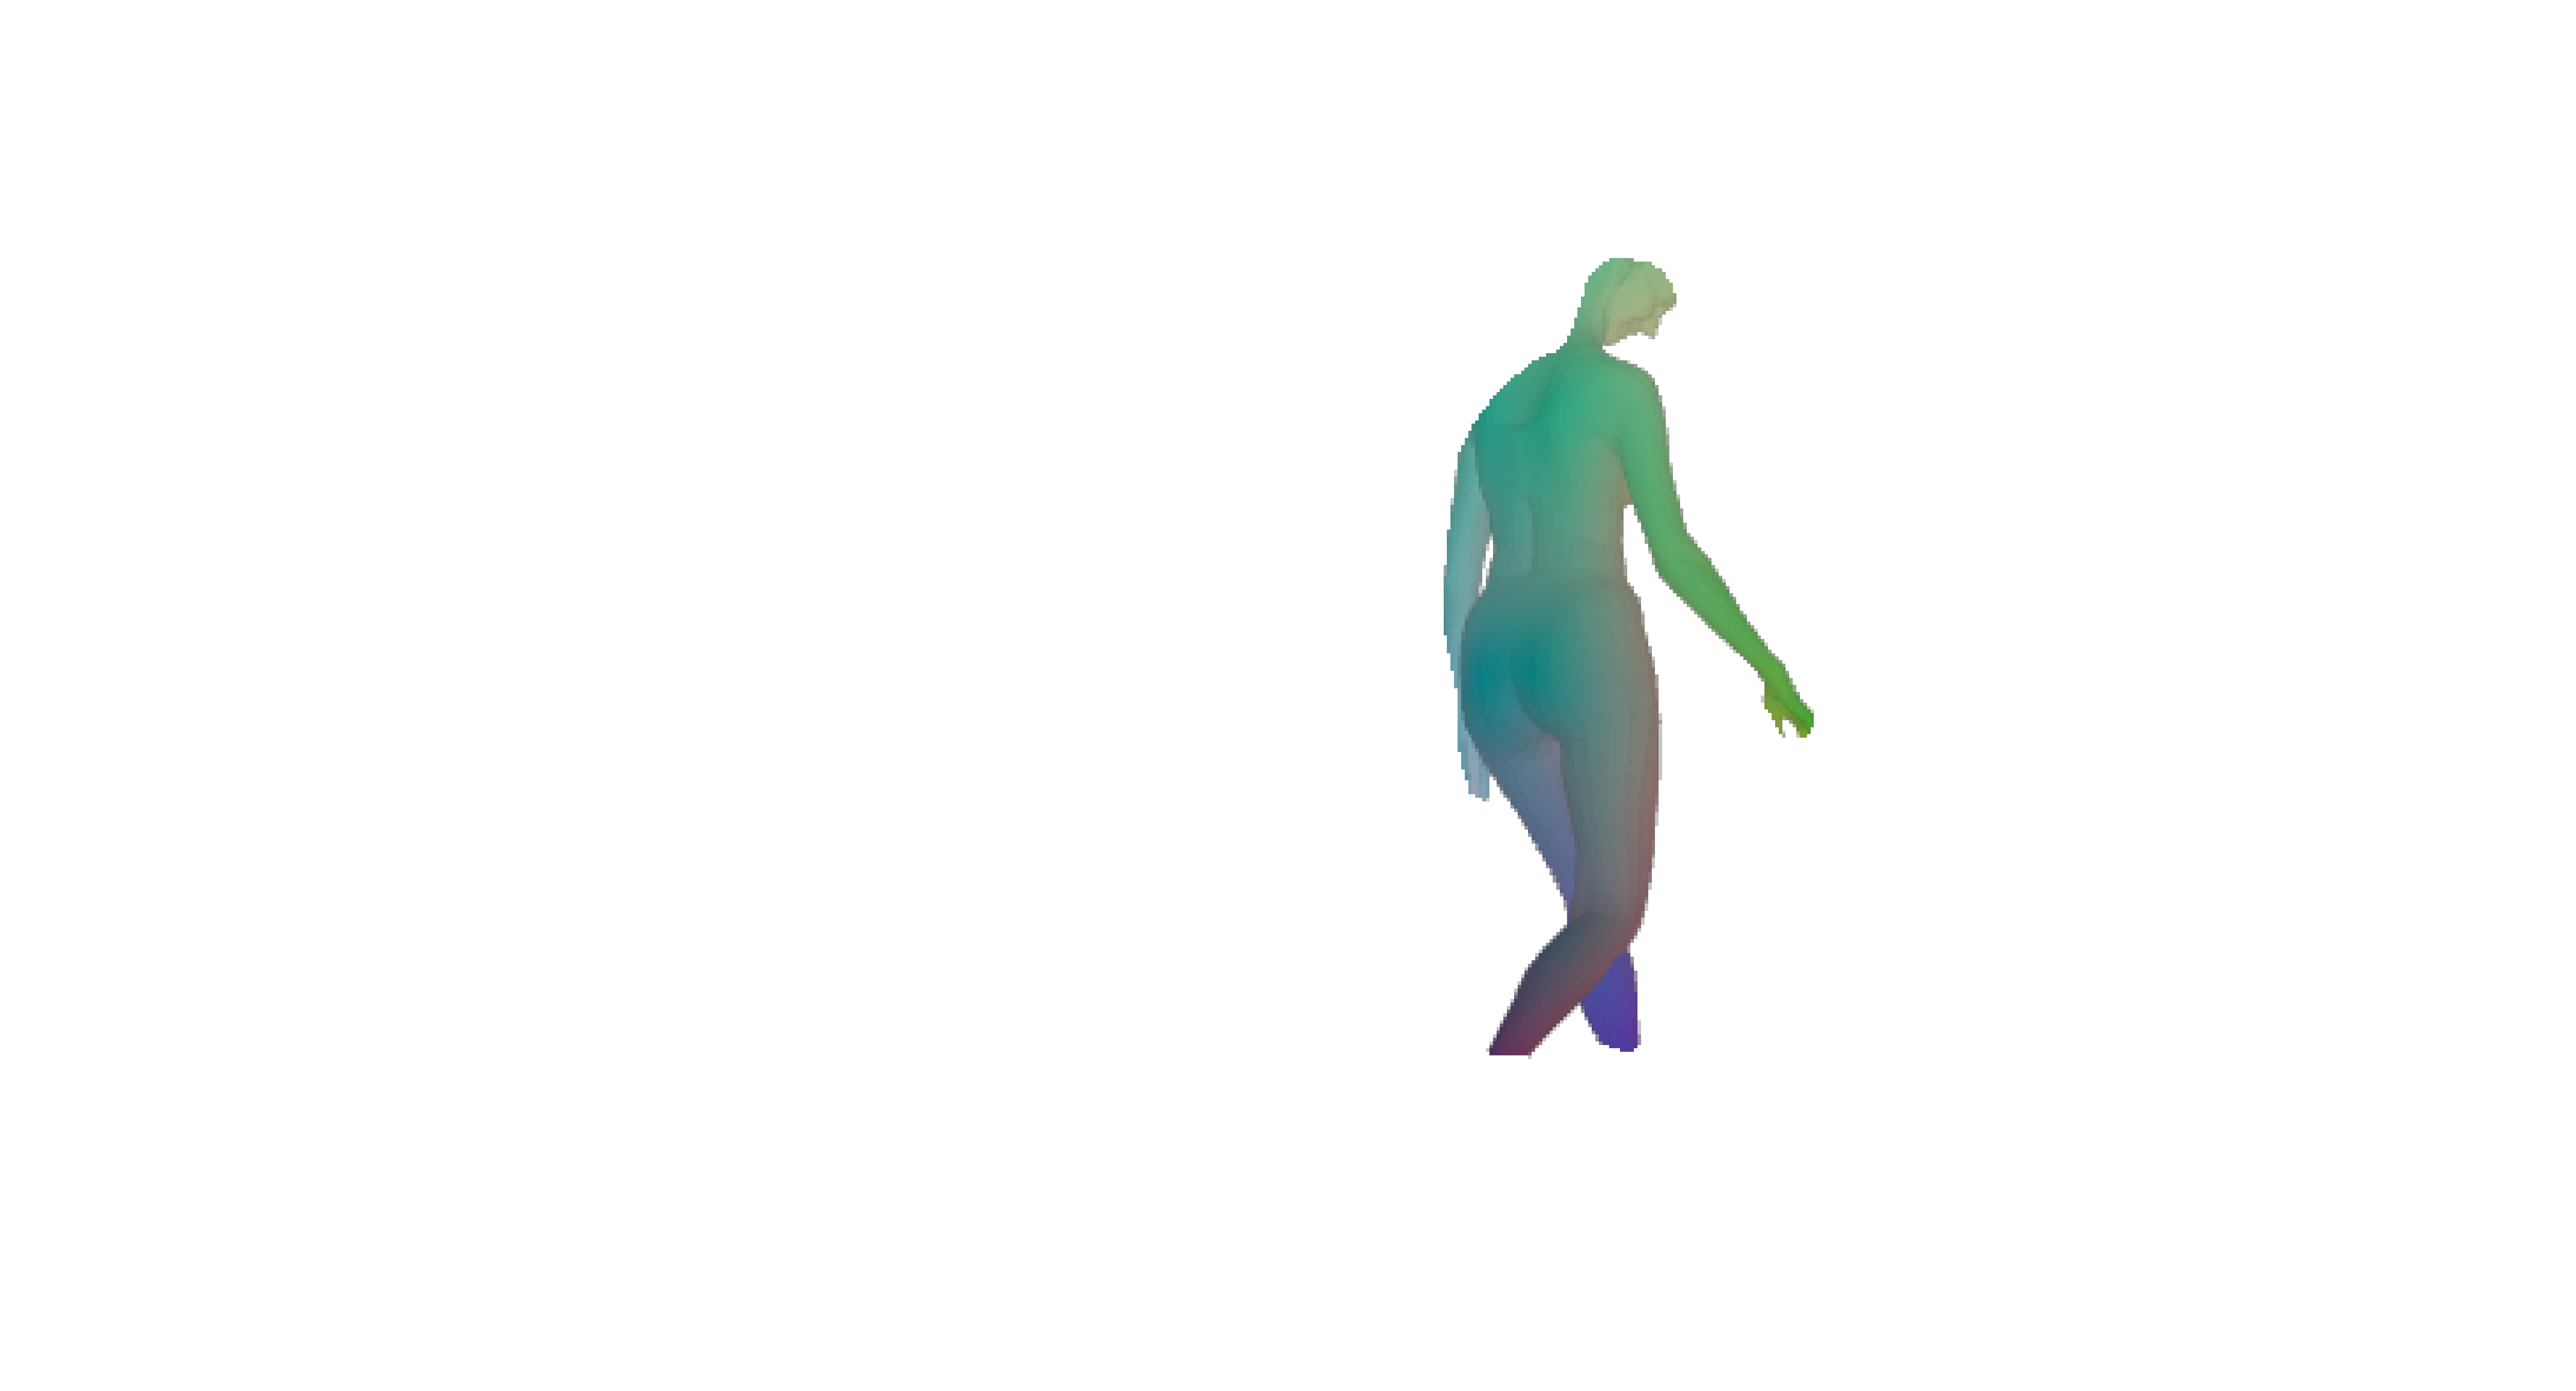

In [ ]:
plt.figure(figsize=(20,10),dpi=400)
final = cv2.subtract(model, occ)
plt.imshow(final)
plt.xticks([])
plt.yticks([])
plt.axis('off')

(-0.5, 719.5, 383.5, -0.5)

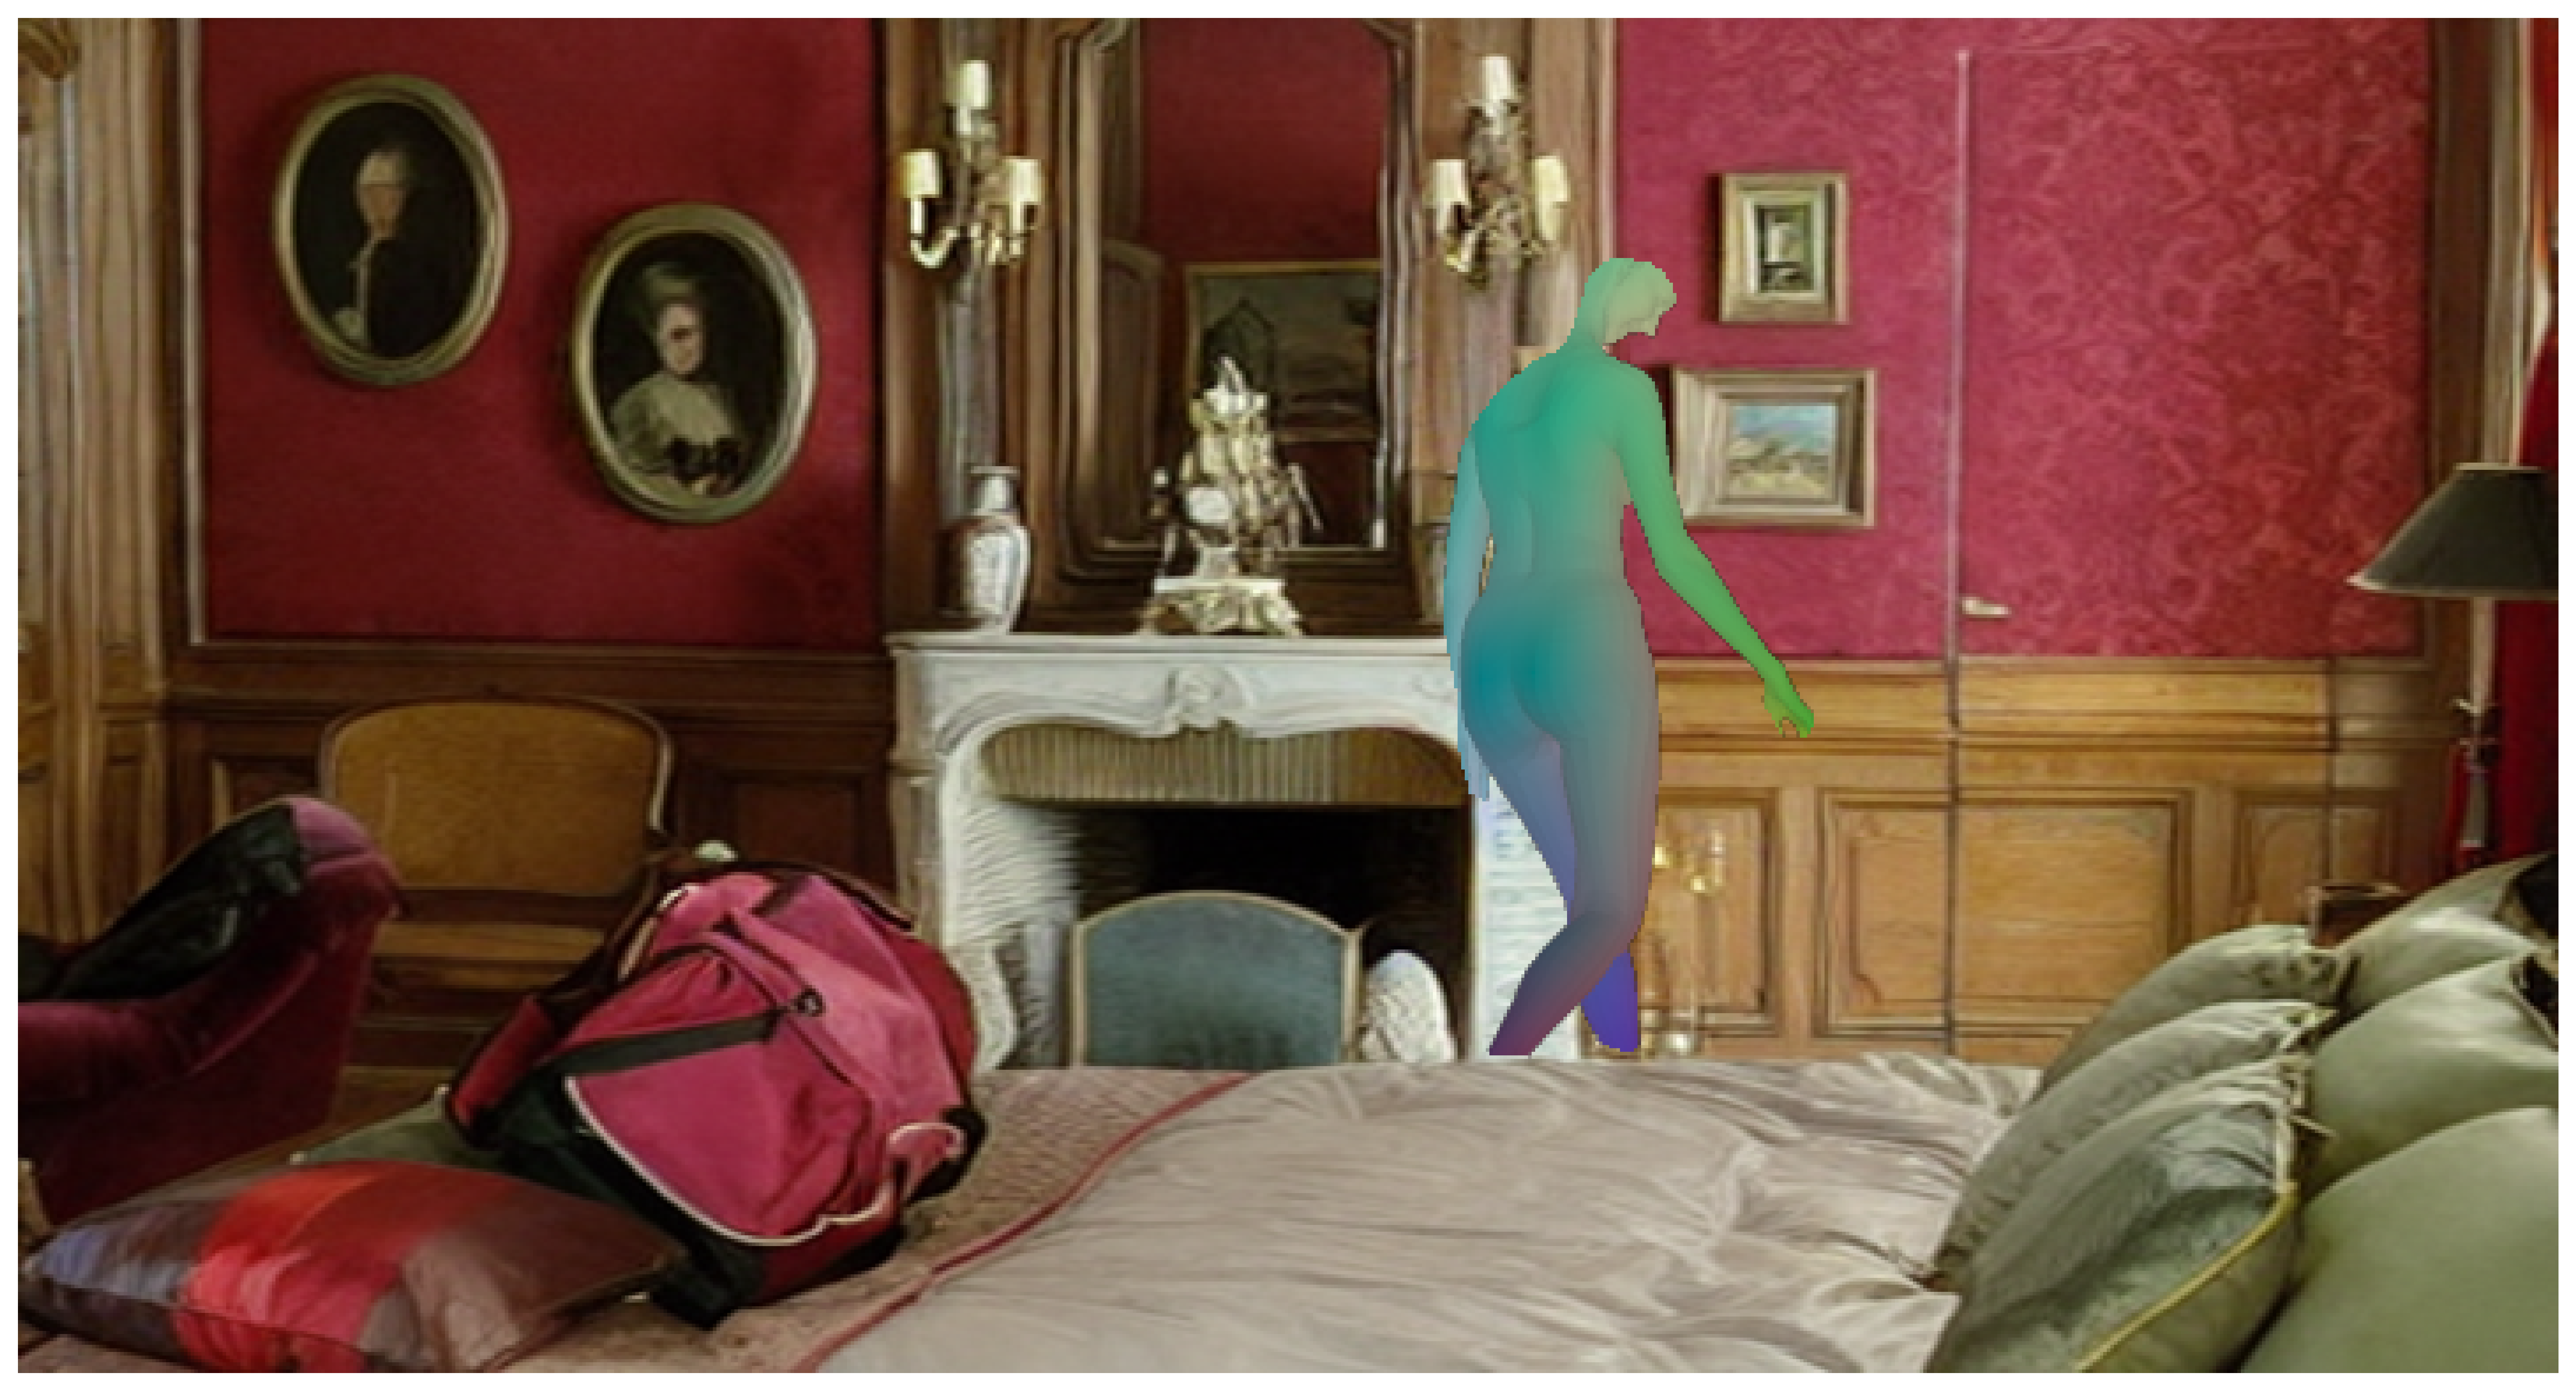

In [ ]:
plt.figure(figsize=(20,10),dpi=400)
final = cv2.subtract(model, occ)
#plt.imshow(bckg_list[23])
plt.imshow(bckgclean_list[5])
plt.imshow(final)
plt.xticks([])
plt.yticks([])
plt.axis('off')

(-0.5, 719.5, 383.5, -0.5)

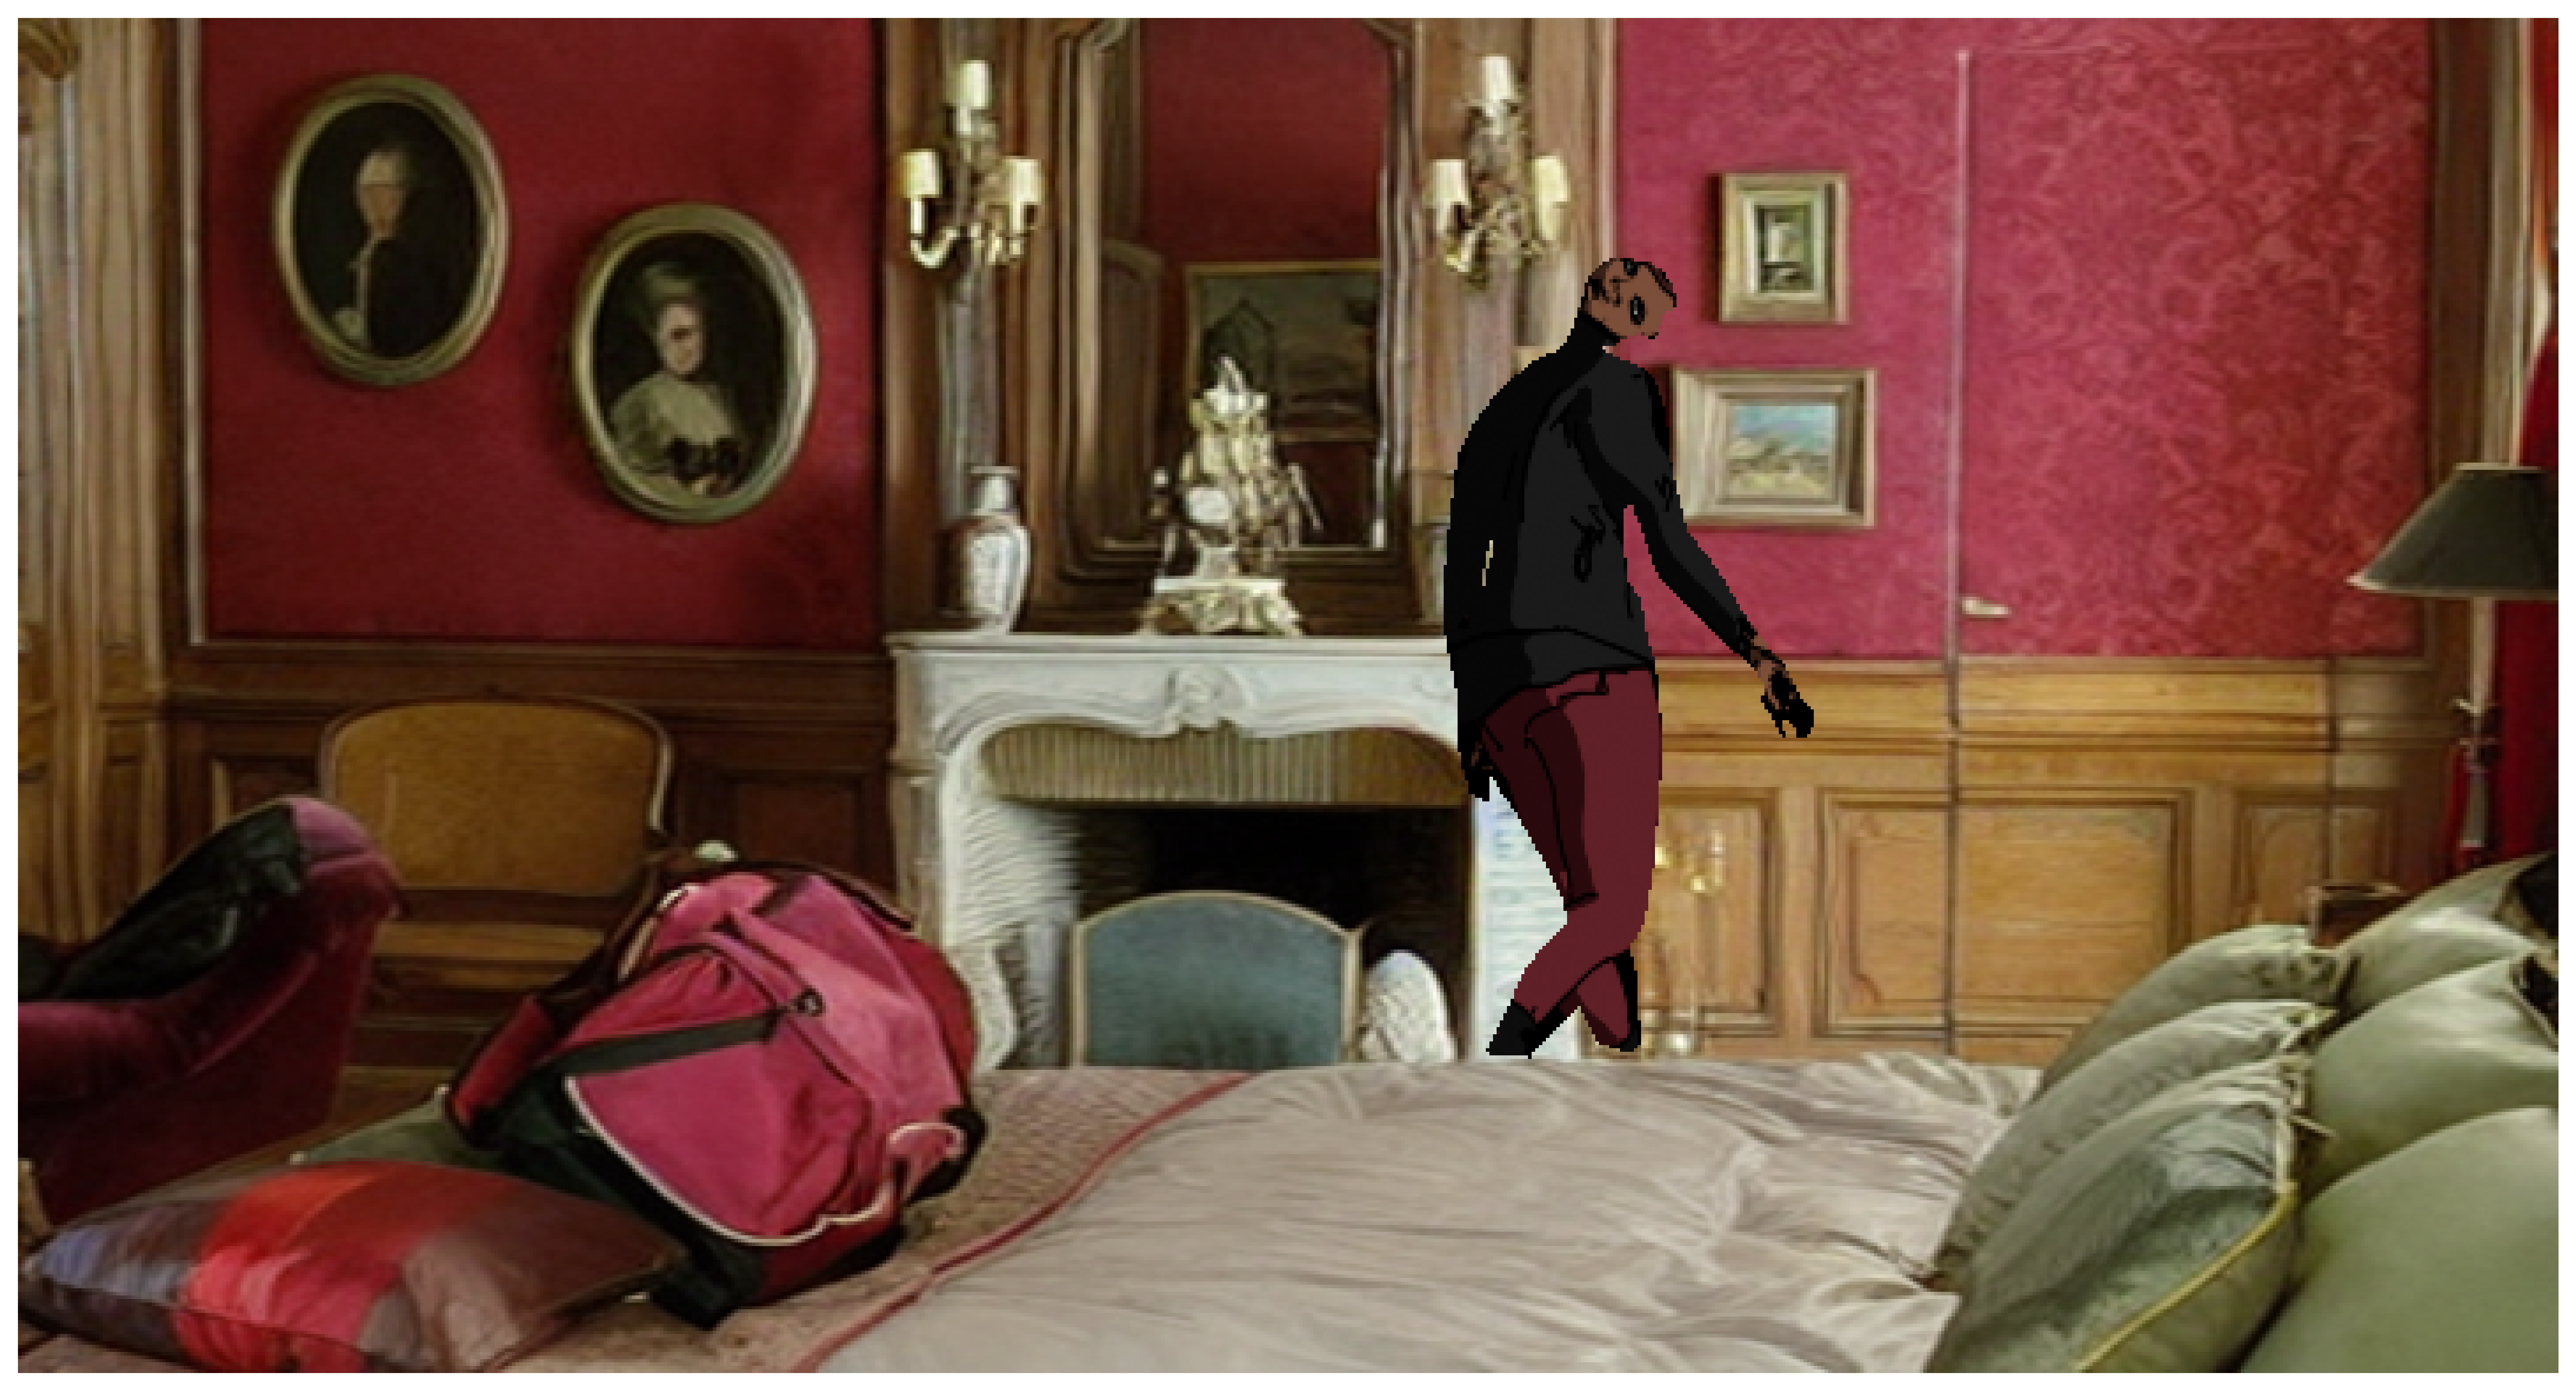

In [ ]:
plt.figure(figsize=(20,10),dpi=400)

cartoon = load_rgb('/content/image0002.png')
#fons = load_rgb('/content/001_background_Hosoda.jpg')
cartoon = cv2.cvtColor(cartoon, cv2.COLOR_RGB2RGBA)
#cartoon = cartoon[int(2*cartoon.shape[0]/11):int(9*cartoon.shape[0]/11), int(2*cartoon.shape[1]/11):int(9*cartoon.shape[1]/11)]

cartoon = cv2.resize(cartoon, (occ.shape[1], occ.shape[0]))
cartoon[np.where(cartoon[:, :, 3] == 0)] = (0, 0, 0, 0)
final_cartoon = cartoon.copy()
final_cartoon[np.where(occ[:, :, 3] > 0)] = (0, 0, 0, 0)
final_cartoon[np.where(model[:, :, 3] == 0)] = (0, 0, 0, 0)
#plt.imshow(bckg_list[23])
plt.imshow(bckgclean_list[5])
plt.imshow(final_cartoon)
plt.xticks([])
plt.yticks([])
plt.axis('off')

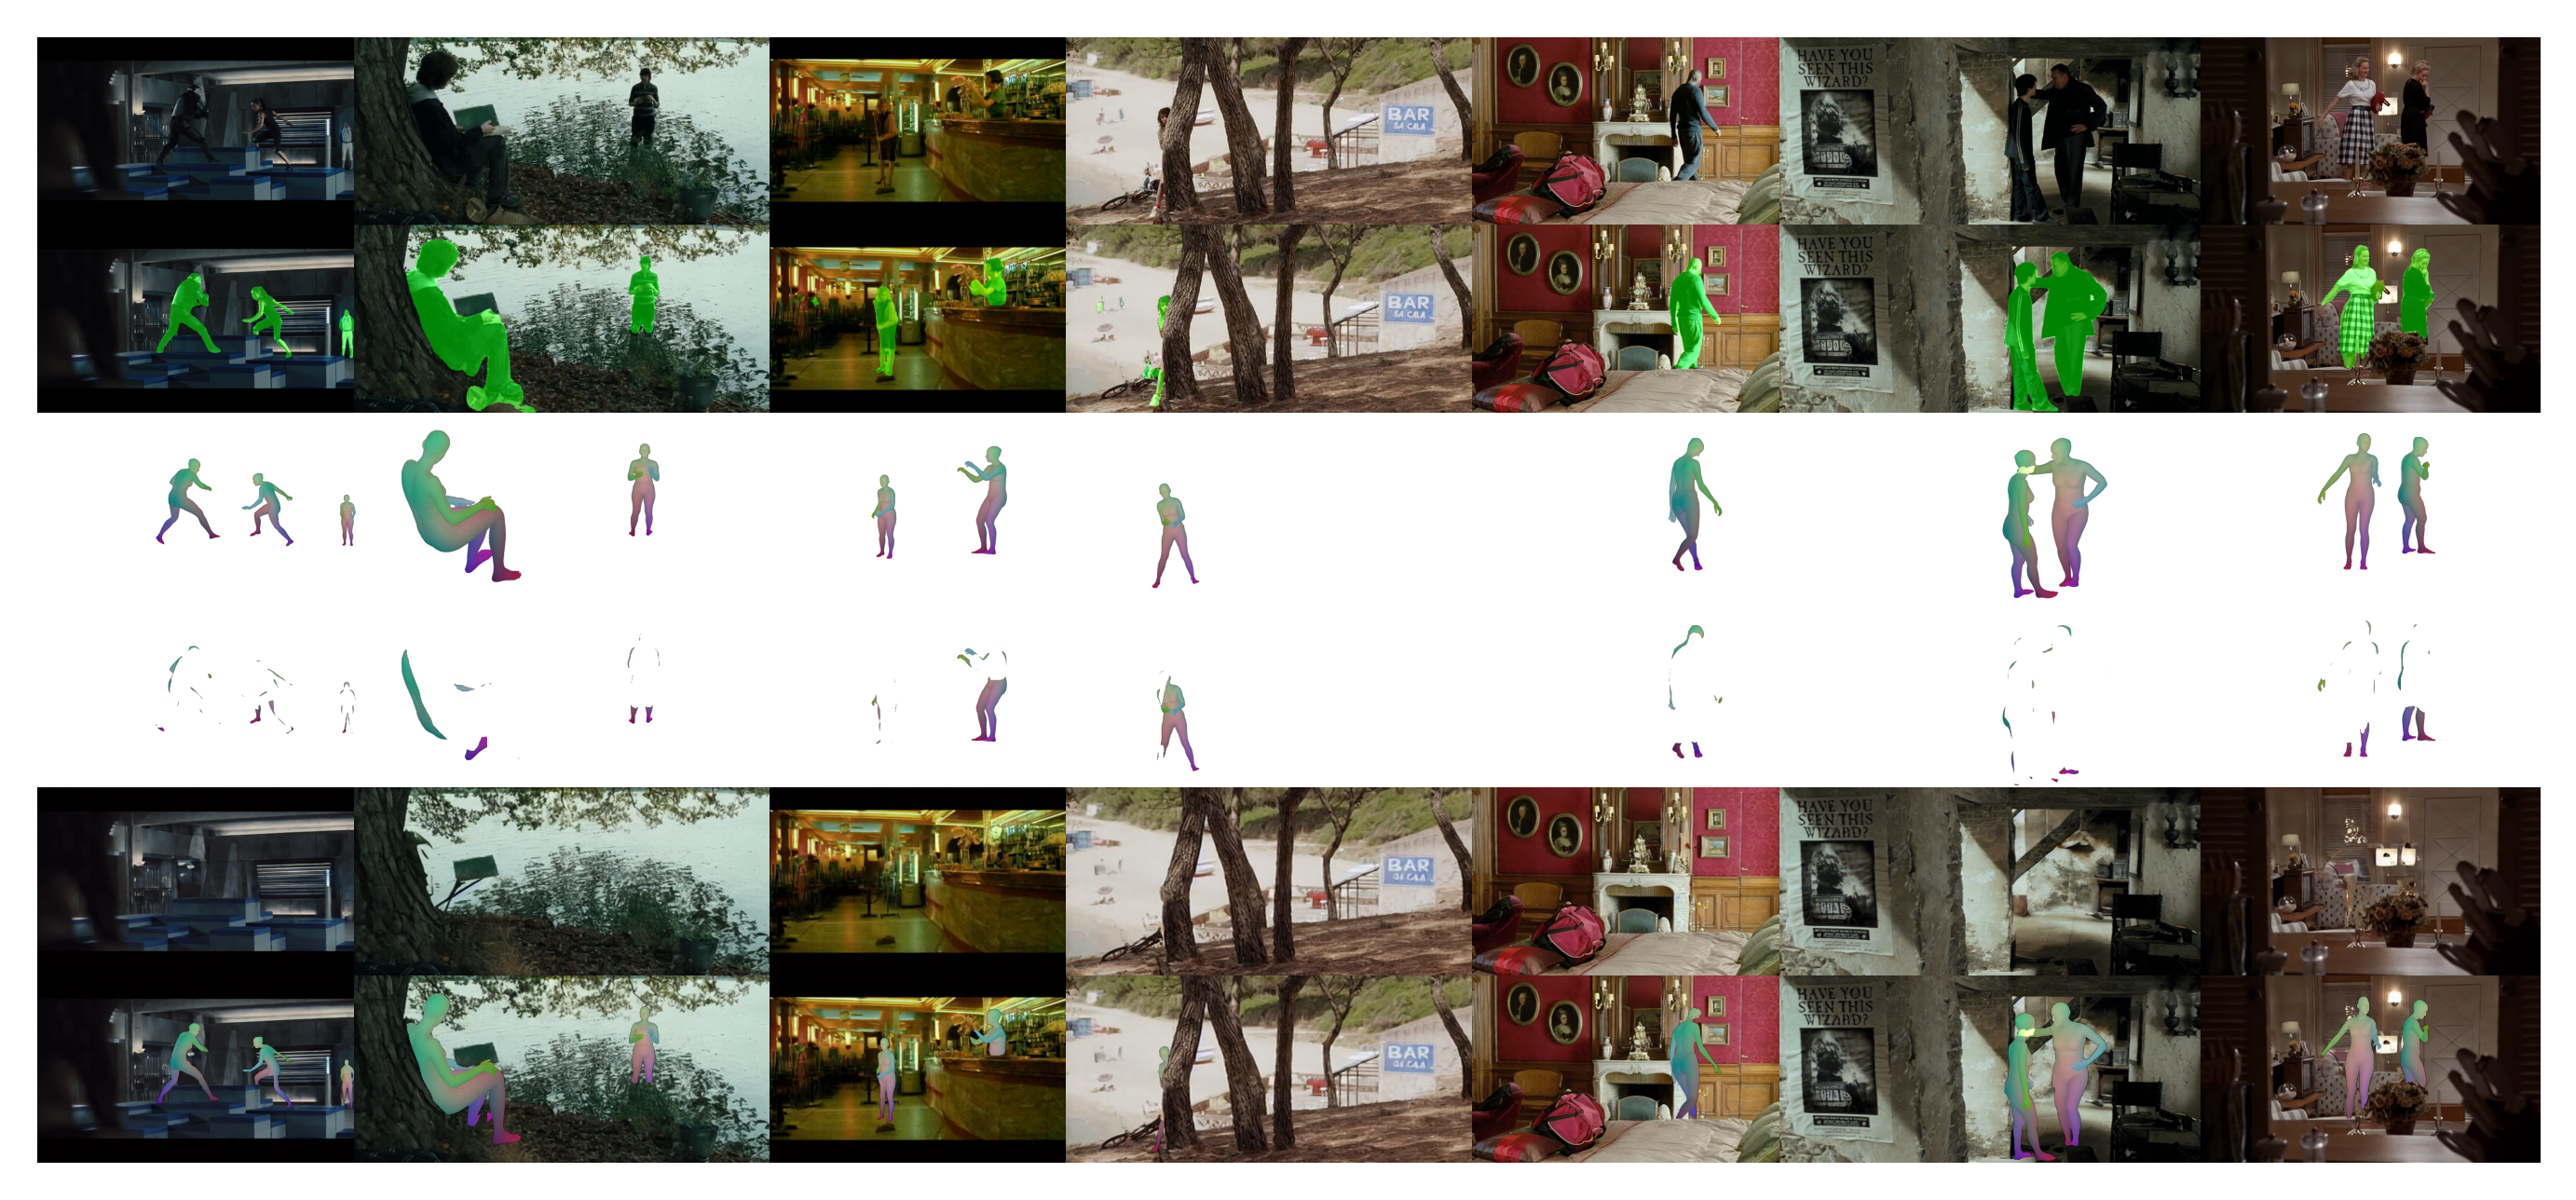

In [ ]:
vec = [2, 7, 4, 21, 25, 1, 3]
plt.figure(figsize=(10,4),dpi=400)

for ii in range(len(vec)):
  jj = vec[ii]

  plt.subplot(6, len(vec), ii + 1)
  plt.imshow(ref_vec[jj])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

  plt.subplot(6, len(vec), ii + 1 + len(vec))
  plt.imshow(dst_vec[jj])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

  model = mesh_list[jj].copy()
  plt.subplot(6, len(vec), ii + 1 + 2*len(vec))
  plt.imshow(model)
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

  mask = mask_vec[jj].copy()
  mask = (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGBA) * (0, 255, 0, 1)).astype(np.uint8)
  occ = model.copy()
  occ[np.where(mask[:, :, 1] == 255)] = (0, 0, 0, 0)
  plt.subplot(6, len(vec), ii + 1 + 3*len(vec))
  plt.imshow(occ)
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

  plt.subplot(6, len(vec), ii + 1 + 4*len(vec))
  plt.imshow(bckgclean_list[jj])
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')

  final = cv2.subtract(model, occ)
  plt.subplot(6, len(vec), ii + 1 + 5*len(vec))
  plt.imshow(bckgclean_list[jj])
  plt.imshow(final)
  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  
plt.subplots_adjust(wspace=-0.5, hspace=0)